<a id='top'></a>

# 2) Gradient Boosted Chance Quality Model from Shots Data
##### Notebook to further improve the Chance Quality Model (CQM) model created in the previous notebook, from a provided sample of just under 11,000 shots, through the application of the XGBoost Gradient Boosting algorithm.

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 26/03/2021<br>
Notebook last updated: 11/04/2021

![title](../../../../../img/expected_goals_visual.png)

Photo credit to David Sumpter ([@Soccermatics](https://twitter.com/Soccermatics?)).

---

## <a id='introduction'>Introduction</a>
This notebook is a short walk-through of how to create an Expected Goals (xG) model using a just under 11,00 shots, in [Python](https://www.python.org/), using [pandas](http://pandas.pydata.org/) DataFrames, [scikit-learn](https://scikit-learn.org/stable/) and [XGBoost](https://xgboost.readthedocs.io/en/latest/) for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) visualisations.

For more information about this notebook and the author, I am available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/); and
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster).

![title](../../../../../img/edd_webster/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/mcfc_submission/) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/mcfc_submission/blob/main/notebooks/chance_quality_modelling/Creating%20a%20Chance%20Quality%20Model%20from%20Shots%20Data.ipynb).

___

## <a id='notebook_contents'>Notebook Contents</a>
1.      [Notebook Dependencies](#section1)<br>
2.      [Project Brief](#section2)<br>
3.      [Introduction to XGBoost](#section3)<br>
4.      [Bagging Vs. Boosting](#section4)<br>
5.      [Theory Behind the XGBoost Algorithm](#section5)<br>
6.      [Data Sources](#section6)<br>
        1.    [Data Dictionary](#section6.1)<br>
        2.    [Creating the DataFrame](#section6.2)<br>
        3.    [Initial Data Handling](#section6.3)<br>    
7.      [Initial Modeling](#section7)<br>
8.      [k-fold Cross Validation using XGBoost](#section8)<br>
9.      [Feature Importance with XGBoost](#section9)<br>
10.     [Visualisation of XGBoost Tree](#section10)<br>
11.     [Hyperparameter Optimisation](#section11)<br>
12.     [Final Optimised XGBoost Model](#section12)<br>
13.     [Performance comparison of XGBoost with Logistic Regression](#section13)<br>
14.     [Assessment of the Performance of the Teams in Game 2 of the Metrica Sports Shot Data](#section14)<br>
15.     [Summary](#section15)<br>
16.     [Next Steps](#section16)<br>
17.     [References and Further Reading](#section17)<br>

---

## <a id='#section1'>1. Notebook Dependencies</a>
This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations; and
*    [`scikit-learn`](https://scikit-learn.org/stable/index.html) for Machine Learning.

All packages used for this notebook except can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
%load_ext autoreload
%autoreload 2

# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Arc
from matplotlib.colors import ListedColormap
import plotly
import plotly.graph_objects as go
import ruamel.yaml
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno
from xgboost import plot_tree
import graphviz

# Downloading data sources
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
from tqdm import tqdm

# Football libraries
#import FCPython
#from FCPython import createPitch
#import matplotsoccer

# Machine Learning
import scipy as sp
from scipy.spatial import distance
import sklearn
from sklearn.ensemble import RandomForestClassifier, IsolationForest
#from sklearn.inspection import permutation_importance
import sklearn.metrics as sk_metrics
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score , roc_curve, average_precision_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from scikitplot.metrics import plot_roc_curve, plot_precision_recall_curve, plot_calibration_curve
import pickle
import shap
#import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier, cv

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))
print('Plotly: {}'.format(plotly.__version__))

Python: 3.7.6
NumPy: 1.18.0
pandas: 1.2.0
matplotlib: 3.3.2
Seaborn: 0.11.1
Plotly: 4.14.3


### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [4]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_shots = os.path.join(base_dir, 'data', 'shots')
data_dir_metrica = os.path.join(base_dir, 'data', 'metrica-sports')
models_dir = os.path.join(base_dir, 'models')
models_dir_shots = os.path.join(base_dir, 'models', 'shots')
scripts_dir = os.path.join(base_dir, 'scripts')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
fig_shots_dir = os.path.join(base_dir, 'img', 'fig', 'shots')
video_dir = os.path.join(base_dir, 'video')

### Custom Functions

In [5]:
# Simple timer function to time XGBoost algorithms
def timer(start_time=None):
    if not start_time:
        start_time = datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [6]:
# Custom function to draw a football pitch in Plotly by Clemens Krause (@CleKraus). See: https://github.com/CleKraus/soccer_analytics/blob/master/helper/plotly.py
def draw_pitch_plotly(below=False,
                      colour='city-blue',
                      line_colour=None,
                      size=1,
                      len_field=105,
                      wid_field=68
                     ):
    """
    Function returns a plotly figure of a soccer field.
    :param below: (bool) If true, any additional traces will overlay the field; otherwise, the field will overlay the
                         additional traces
    :param colour: (str) Colour of the field; currently only "green" and "white" are supported
    :param line_colour: (str) Colour of the line; if none it is automatically set based on the field colour
    :param size: (float) Size relative to the standard size
    :param len_field: (int) Length of soccer field in meters (needs to be between 90m and 120m)
    :param wid_field: (int) Width of soccer field in meters (needs to be between 60m and 90m)
    :return: go.Figure with a soccer field
    """

    # check the input for correctness
    assert 90 <= len_field <= 120
    assert 60 <= wid_field <= 90
    assert colour in ['city-blue', 'green', 'white']
    assert type(below) is bool

    # size for center point and penalty points
    size_point = 0.5

    field_colour = "rgba(240,248,255)" if colour == "city-blue" else "white"

    if line_colour is None:
        line_colour = "midnightblue" if colour == "city-blue" else "black"

    # set the overall layout of the field
    layout = go.Layout(
        # make sure the field is green
        plot_bgcolor=field_colour,
        xaxis=dict(
            range=[-5, len_field + 5],
            zeroline=False,
            showgrid=False,
            showticklabels=False,
        ),
        yaxis=dict(
            range=[-5, wid_field + 5],
            zeroline=False,
            showgrid=False,
            showticklabels=False,
        ),
    )

    # create an empty figure for which only the layout is set
    fig = go.Figure(layout=layout)

    # add the halfway line
    ######################
    fig.add_shape(
        dict(
            type="line",
            x0=len_field / 2,
            y0=0,
            x1=len_field / 2,
            y1=wid_field,
            line=dict(color=line_colour, width=2),
        )
    )

    # add left penalty area
    ########################
    y_box = (wid_field - 40.32) / 2
    x_vals = [0, 16, 16, 0]
    y_vals = [wid_field - y_box, wid_field - y_box, y_box, y_box]

    for i in range(len(x_vals) - 1):
        fig.add_shape(
            # Line Vertical
            dict(
                type="line",
                x0=x_vals[i],
                y0=y_vals[i],
                x1=x_vals[i + 1],
                y1=y_vals[i + 1],
                line=dict(color=line_colour, width=2),
            )
        )

    # add left goal area
    ####################
    y_small_box = 7.32 / 2 + 5.5
    x_vals = [0, 5.5, 5.5, 0]
    y_vals = [
        wid_field / 2 - y_small_box,
        wid_field / 2 - y_small_box,
        wid_field / 2 + y_small_box,
        wid_field / 2 + y_small_box,
    ]

    for i in range(len(x_vals) - 1):
        fig.add_shape(
            # Line Vertical
            dict(
                type="line",
                x0=x_vals[i],
                y0=y_vals[i],
                x1=x_vals[i + 1],
                y1=y_vals[i + 1],
                line=dict(color=line_colour, width=2),
            )
        )

    # add right penalty area
    ########################
    x_vals = [len_field, len_field - 16, len_field - 16, len_field]
    y_vals = [wid_field - y_box, wid_field - y_box, y_box, y_box]

    for i in range(len(x_vals) - 1):
        fig.add_shape(
            # Line Vertical
            dict(
                type="line",
                x0=x_vals[i],
                y0=y_vals[i],
                x1=x_vals[i + 1],
                y1=y_vals[i + 1],
                line=dict(color=line_colour, width=2),
            )
        )

    # add right goal area
    #####################
    y_small_box = 7.32 / 2 + 5.5
    x_vals = [len_field, len_field - 5.5, len_field - 5.5, len_field]
    y_vals = [
        wid_field / 2 - y_small_box,
        wid_field / 2 - y_small_box,
        wid_field / 2 + y_small_box,
        wid_field / 2 + y_small_box,
    ]

    for i in range(len(x_vals) - 1):
        fig.add_shape(
            # Line Vertical
            dict(
                type="line",
                x0=x_vals[i],
                y0=y_vals[i],
                x1=x_vals[i + 1],
                y1=y_vals[i + 1],
                line=dict(color=line_colour, width=2),
            )
        )

    # add left penalty point
    ########################
    pen_point = (11, wid_field / 2)
    x_vals = [pen_point[0] - size_point, pen_point[0] + size_point]
    y_vals = [pen_point[1] - size_point, pen_point[1] + size_point]

    fig.add_shape(
        # unfilled circle
        dict(
            type="circle",
            xref="x",
            yref="y",
            x0=x_vals[0],
            y0=y_vals[0],
            x1=x_vals[1],
            y1=y_vals[1],
            line_color=line_colour,
            fillcolor=line_colour,
        )
    )

    # add right penalty point
    #########################
    pen_point = (len_field - 11, wid_field / 2)
    x_vals = [pen_point[0] - size_point, pen_point[0] + size_point]
    y_vals = [pen_point[1] - size_point, pen_point[1] + size_point]

    fig.add_shape(
        # unfilled circle
        dict(
            type="circle",
            xref="x",
            yref="y",
            x0=x_vals[0],
            y0=y_vals[0],
            x1=x_vals[1],
            y1=y_vals[1],
            line_color=line_colour,
            fillcolor=line_colour,
        )
    )

    # add center spot
    #################
    pen_point = (len_field / 2, wid_field / 2)
    x_vals = [pen_point[0] - size_point, pen_point[0] + size_point]
    y_vals = [pen_point[1] - size_point, pen_point[1] + size_point]

    fig.add_shape(
        dict(
            type="circle",
            xref="x",
            yref="y",
            x0=x_vals[0],
            y0=y_vals[0],
            x1=x_vals[1],
            y1=y_vals[1],
            line_color=line_colour,
            fillcolor=line_colour,
        )
    )

    # add center circle
    ###################

    # radius of the center circle (in meters)
    rad_circle = 9.15

    circle_y = wid_field / 2 - rad_circle
    circle_x = len_field / 2 - rad_circle

    fig.add_shape(
        dict(
            type="circle",
            xref="x",
            yref="y",
            x0=circle_x,
            y0=circle_y,
            x1=len_field - circle_x,
            y1=wid_field - circle_y,
            line_color=line_colour,
        )
    )

    # add outer lines
    ###################

    fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=0,
            x1=len_field,
            y1=0,
            line=dict(color=line_colour, width=2),
        )
    )

    # add the out lines
    fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=0,
            x1=0,
            y1=wid_field,
            line=dict(color=line_colour, width=2),
        )
    )

    # add the out lines
    fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=wid_field,
            x1=len_field,
            y1=wid_field,
            line=dict(color=line_colour, width=2),
        )
    )

    # add the out lines
    fig.add_shape(
        dict(
            type="line",
            x0=len_field,
            y0=0,
            x1=len_field,
            y1=wid_field,
            line=dict(color=line_colour, width=2),
        )
    )

    # add goals
    ###########

    goal_width = 7.32

    # left goal
    fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=(wid_field - goal_width) / 2,
            x1=-2,
            y1=(wid_field - goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=(wid_field + goal_width) / 2,
            x1=-2,
            y1=(wid_field + goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    fig.add_shape(
        dict(
            type="line",
            x0=-2,
            y0=(wid_field - goal_width) / 2,
            x1=-2,
            y1=(wid_field + goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    # right goal
    fig.add_shape(
        dict(
            type="line",
            x0=len_field,
            y0=(wid_field - goal_width) / 2,
            x1=len_field + 2,
            y1=(wid_field - goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    fig.add_shape(
        dict(
            type="line",
            x0=len_field,
            y0=(wid_field + goal_width) / 2,
            x1=len_field + 2,
            y1=(wid_field + goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    fig.add_shape(
        dict(
            type="line",
            x0=len_field + 2,
            y0=(wid_field - goal_width) / 2,
            x1=len_field + 2,
            y1=(wid_field + goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    # configure the layout such that additional traces overlay the field
    if below:
        for shape in fig.layout["shapes"]:
            shape["layer"] = "below"

    # update the layout such that the field looks symmetrical
    fig.update_layout(
        autosize=False, width=len_field * 8 * size, height=wid_field * 9 * size
    )

    return fig

In [7]:
# Custom function to draw a football pitch in matplotlib by Peter McKeever. See: http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/
def draw_pitch_mpl(x_min=0,
                   x_max=106,
                   y_min=0,
                   y_max=68,
                   pitch_color="w",
                   line_color="grey",
                   line_thickness=1.5,
                   point_size=20,
                   orientation="horizontal",
                   aspect="full",
                   ax=None
                  ):

    if not ax:
        raise TypeError("This function is intended to be used with an existing fig and ax in order to allow flexibility in plotting of various sizes and in subplots.")


    if orientation.lower().startswith("h"):
        first = 0
        second = 1
        arc_angle = 0

        if aspect == "half":
            ax.set_xlim(x_max / 2, x_max + 5)

    elif orientation.lower().startswith("v"):
        first = 1
        second = 0
        arc_angle = 90

        if aspect == "half":
            ax.set_ylim(x_max / 2, x_max + 5)

    
    else:
        raise NameError("You must choose one of horizontal or vertical")

    
    ax.axis("off")

    rect = plt.Rectangle((x_min, y_min),
                         x_max, y_max,
                         facecolor=pitch_color,
                         edgecolor="none",
                         zorder=-2)

    ax.add_artist(rect)

    x_conversion = x_max / 100
    y_conversion = y_max / 100

    pitch_x = [0,5.8,11.5,17,50,83,88.5,94.2,100] # pitch x markings
    pitch_x = [x * x_conversion for x in pitch_x]

    pitch_y = [0, 21.1, 36.6, 50, 63.2, 78.9, 100] # pitch y markings
    pitch_y = [x * y_conversion for x in pitch_y]

    goal_y = [45.2, 54.8] # goal posts
    goal_y = [x * y_conversion for x in goal_y]

    # side and goal lines
    lx1 = [x_min, x_max, x_max, x_min, x_min]
    ly1 = [y_min, y_min, y_max, y_max, y_min]

    # outer boxed
    lx2 = [x_max, pitch_x[5], pitch_x[5], x_max]
    ly2 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    lx3 = [0, pitch_x[3], pitch_x[3], 0]
    ly3 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    # goals
    lx4 = [x_max, x_max+2, x_max+2, x_max]
    ly4 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    lx5 = [0, -2, -2, 0]
    ly5 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    # 6 yard boxes
    lx6 = [x_max, pitch_x[7], pitch_x[7], x_max]
    ly6 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]

    lx7 = [0, pitch_x[1], pitch_x[1], 0]
    ly7 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]


    # Halfway line, penalty spots, and kickoff spot
    lx8 = [pitch_x[4], pitch_x[4]]
    ly8 = [0, y_max]

    lines = [
        [lx1, ly1],
        [lx2, ly2],
        [lx3, ly3],
        [lx4, ly4],
        [lx5, ly5],
        [lx6, ly6],
        [lx7, ly7],
        [lx8, ly8],
        ]

    points = [
        [pitch_x[6], pitch_y[3]],
        [pitch_x[2], pitch_y[3]],
        [pitch_x[4], pitch_y[3]]
        ]

    circle_points = [pitch_x[4], pitch_y[3]]
    arc_points1 = [pitch_x[6], pitch_y[3]]
    arc_points2 = [pitch_x[2], pitch_y[3]]


    for line in lines:
        ax.plot(line[first], line[second],
                color=line_color,
                lw=line_thickness,
                zorder=-1)

    for point in points:
        ax.scatter(point[first], point[second],
                   color=line_color,
                   s=point_size,
                   zorder=-1)

    circle = plt.Circle((circle_points[first], circle_points[second]),
                        x_max * 0.088,
                        lw=line_thickness,
                        color=line_color,
                        fill=False,
                        zorder=-1)

    ax.add_artist(circle)

    arc1 = Arc((arc_points1[first], arc_points1[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=128.75,
               theta2=231.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc1)

    arc2 = Arc((arc_points2[first], arc_points2[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=308.75,
               theta2=51.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc2)

    ax.set_aspect("equal")

    return ax

### Notebook Settings

In [8]:
# Display all columns of pandas DataFrames
pd.set_option('display.max_columns', None)

---

## <a id='#section2'>2. Project Brief</a>

### <a id='#section2.1'>2.1. About this notebook</a>
In most real-world machine-learning tasks, a well-calibrated gradient booster such as lightGBM or XGBoost outperforms Logistic Regression when using the same set of features.

Often, smartly, hand-crafted features can bring a Logistic Regression to an (almost) similiar performance as when using Gradient Boosting algorithms. This is especially true when dealing with rather simple problems with a relatively small number of features.

Using the engineered dataset in the first notebook, the following sections build upon this modeling, using gradient boosting algorithms, to try and further reduce the Log Loss of the model and improve upon the potential predictions made upon the Metrica Sports data, to analyse which team was more deserving to with the game based solely on the chances created.

This notebook builds upon the work conducted in the first Chance Quality notebook, created using a trained Logistic Regression model, and to further improve the performance using [XGBoost](https://xgboost.readthedocs.io/en/latest/) . The model uses the engineered dataset of 11,000 shots dervied in the previous notebook, using [pandas](http://pandas.pydata.org/) DataFrames for data manipulation and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) for data visualisation.

**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

### <a id='#section2.2'>2.2. Challenge</a>
Defined in the previous notebook but included here as a reminders of the big picture.

<b>Step 1:</b>
We have attached to this email a sample of just under 11,000 shots (ShotData.csv, and the associated description in ShotData.txt). We would like you to use this data to build a chance quality model that calculates the probability of a shot resulting in a goal (i.e. P[goal|shot,situation]) using whichever situational variables in the data you think are informative. We ask that you provide a description of the method that you chose, including any metrics and plots that you have used to understand and assess the performance of your model. This description may take the form of a short written report (no more than one page of text plus additional room for figures & tables) or a slide pack (PowerPoint, Google slides, etc; no more than a total of 10 slides).

<b>Step 2:</b>
In the second step we ask you to work with the tracking data for a single game to analyse the shooting opportunities that each team created. In this github repository* you will find the tracking data for two matches, along with a description of the data. Using the data for sample game 2 in the repository, identify the shots in this game and write a short report describing the major chances that each team created during the game, making use of the chance quality model that you developed in Step 1 and any other information that you think is relevant. Based solely on the quality of chances that each team created, which team do you think deserved to win the game? Your report may take the form of a document (1 page plus additional room for figures & tables) or presentation (no more than 10 slides).

This notebook is concerned with <b>Step 1</b> - building a Chance Quality Model, using XGBoost.

### <a id='#section2.3'>2.3. What is XGBoost?</a>
XGBoost stands for **eXtreme Gradient Boosting** and is a performant Machine Learning algorithm based on the paper [Greedy Function Approximation: A Gradient Boosting Machine by Friedman](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf). XGBoost implements a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) algorithm based on decision trees.

This notebook aims to hopefully serve as an explanatory guide of XGBoost for beginners and those with previous experience alike and goes into much more detail about this algorithm in the follow sections

### <a id='#section2.4'>2.4. Modelling Approach</a>
This model will build upon the work done in the first notebook in the series, that builds a Chance Quality Model from Logistic Regression and looks to improve on the results using the popular XGBoost algorithm. The approach taken in this notebook can be defined as the following:

*    <b>Introduction to XGBoost</b>: introduction to the concept of XGBoost ([section 3](#section3));
*    <b>Bagging Vs. Boosting</b>:  ([section 4](#section4));
*    <b>Theory Behind the XGBoost Algorithm</b>:  ([section 5](#section5));
*    <b>Data Sources</b>:  ([section 6](#section6));
*    <b>Initial Modeling</b>: First model created as a baseline for which iterations of improvement are based. ([section 7](#section7));
*    <b>k-fold Cross Validation using XGBoost</b>: ([section 8](#section8));
*    <b>Feature Importance with XGBoost</b>: ([section 9](#section9));
*    <b>Visualisation of XGBoost Tree</b>: ([section 10](#section10));
*    <b>Hyperparameter Optimisation</b>: ([section 11](#section11));
*    <b>Final Optimised XGBoost Model</b>: ([section 12](#section12));
*    <b>Performance Comparison of XGBoost with Logistic Regression</b>: ([section 13](#section13));
*    <b>Assessment of the Performance of the Teams in Game 2 of the Metrica Sports Shot Data</b>: ([section 14](#section14));
*    <b>Summary</b>: ([section 15](#section15));
*    <b>Next Steps</b>: ([section 16](#section16)); and
*    <b>References and Further Reading</b>: ([section 17](#section17)).

---

## <a id='#section3'>3. Introduction to XGBoost</a>
*    XGBoost stands for **Extreme Gradient Boosting**.
*    It is a performant machine learning library based on the paper [Greedy Function Approximation: A Gradient Boosting Machine by Friedman](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf).
*    It is an open source machine learning library providing a high-performance implementation of gradient boosted decision trees.
*    It is originally written in C++ and is comparatively faster than other ensemble classifiers.
*    It belongs to a family of boosting algorithms and uses the **gradient boosting (GBM)** framework at its core.
*    XGBoost implements a [**Gradient Boosting algorithm**](https://en.wikipedia.org/wiki/Gradient_boosting) based on decision trees.
*    As part of the further explanation, Gradient Boosting algorithms are discussed in later sections.
*    The following link are Please follow the links below for more in-depth discussion on XGBoost.
     +    [XGBoost Official Documentation](https://xgboost.readthedocs.io/en/latest/)
     +    [XGBoost Wiki](https://en.wikipedia.org/wiki/XGBoost)

### <a id='#section3.1'>3.1. What makes XGBoost so popular?</a>
*    Speed and performance : Originally written in C++, it is comparatively faster than other ensemble classifiers.
*    Core algorithm is parallelizable : Because the core XGBoost algorithm is parallelizable it can harness the power of multi-core computers. It is also parallelizable onto GPU’s and across networks of computers making it feasible to train on very large datasets as well.
*    Consistently outperforms other algorithm methods : It has shown better performance on a variety of machine learning benchmark datasets.
*    Wide variety of tuning parameters : XGBoost internally has parameters for cross-validation, regularization, user-defined objective functions, missing values, tree parameters, scikit-learn compatible API etc.

### <a id='#section3.2'>3.2. Evolution of tree-based algorithms </a>
*    The tree based algorithms have evolved over the years.
*    XGBoost belongs to a family of tree-based algorithms.
*    Please see the chart below for the evolution of tree-based algorithms over the years.

![title](../../img/tree_based_algorithms_evolution.jpeg)

### <a id='#section3.3'>3.3. Evolution of tree-based algorithms</a>
*    The primary reasons we should use this algorithm are its **accuracy, efficiency and feasibility**.
*    It is a linear model and a [tree learning](https://en.wikipedia.org/wiki/Decision_tree_learning) algorithm that does parallel computations on a single machine.
*    It also has extra features for doing cross validation and computing feature importance.
*    Given below are some of the main features of the model:
     +    **Sparsity**: It accepts sparse input for tree booster and linear booster.
     +    **Customization**: It supports customized objective and evaluation functions.
     +    **DMatrix**: Its optimized data structure that improves its performance and efficiency.

---

## <a id='#section4'>4. Bagging Vs Boosting</a>
*    To know bagging and boosting, we need to know ensemble methods.
*    Ensemble methods combine several decision trees to produce better predictive performance than utilizing a single decision tree.
*    The main principle behind the ensemble model is that a group of weak learners come together to form a strong learner.
*    Now, we will talk about two techniques to perform ensemble decision trees. These are as follows:
     1.    Bagging
     2.    Boosting

---

### <a id='#section4.1'>4.1. Bagging</a>
*    Bagging (or Bootstrap Aggregation), is a simple and very powerful ensemble method.
*    Bagging is the application of the Bootstrap procedure to a high-variance machine learning algorithm, typically decision trees.
*    The idea behind bagging is combining the results of multiple models (for instance, all decision trees) to get a generalized result.
*    Bagging technique uses these subsets (bags) to get a fair idea of the distribution (complete set). The size of subsets created for bagging may be less than the original set.
*    Bagging had each model run independently and then aggregate the outputs at the end without preference to any model.
*    Bagging can be depicted with the following diagram:

![title](../../img/bagging.png)

---

### <a id='#section4.2'>4.2. Boosting</a>
*    Boosting is a sequential process, where each subsequent model attempts to correct the errors of the previous model. The succeeding models are dependent on the previous model.
*    In this technique, learners are learned sequentially with early learners fitting simple models to the data and then analyzing data for errors. In other words, we fit consecutive trees (random sample) and at every step, the goal is to solve for net error from the prior tree.
*    When an input is misclassified by a hypothesis, its weight is increased so that next hypothesis is more likely to classify it correctly. By combining the whole set at the end converts weak learners into better performing model.
*    Boosting is another ensemble technique to create a collection of models.
*    In this technique, models are learned sequentially with early models fitting simple models to the data and then analyzing the data for errors.
*    In other words, with boosting, we fit consecutive trees and at every step.
*    Boosting can be depicted with the following diagram:

![title](../../img/boosting.png)

---

## <a id='#section5'>5. Theory Behind the XGBoost Algorithm</a>
*    XGBoost is a powerful and lightning fast machine learning library. It’s commonly used to win Kaggle competitions.
*    It’s an intimidating algorithm, especially because of the number of large parameters that XGBoost provides.
*    Also, there is some confusion regarding gradient boosting, gradient boosted trees and XGBoost.
*    So, in this section, we will discuss - **gradient boosting**, **gradient boosted trees** and **XGBoost**. The purpose of this section is to clarify these concepts.

### <a id='#section5.1'>5.1. Gradient Boosting</a>
*    Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
*    It builds the model in a stage-wise fashion like other boosting methods do and it generalizes them by allowing optimization of an arbitrary differentiable loss function.
*    The objective of any supervised learning algorithm is to define a loss function and minimize it. The same is true for Gradient Boosting algorithm. Here, we have mean squared error (MSE) as loss-function defined as follows:

![title](../../img/mse_loss_function_formula.png)

*    We want our predictions, such that our loss function (MSE) is minimum.
*    By using gradient descent and updating our predictions based on a learning rate, we can find the values where MSE is minimum.
*    It can be depicted as follows:

![title](../../img/mse_minima.png)

*    So, we are basically updating the predictions such that the sum of our residuals is close to 0 (or minimum) and predicted values are sufficiently close to actual values.
*    Now, we train our second model on the gradient of the error with respect to the loss predictions of the first model. Thus, we should correct the mistakes of the first model.
*    This is the core of gradient boosting, and what allows many simple models to compensate for each other’s weaknesses to better fit the data.
*    Gradient Boosting is an iterative procedure. So, we will repeat the above process over and over again. Each time we fit a new model to the gradient of the error of the updated sum of models.
*    So, gradient boosting is a method for optimizing the function F, but it doesn’t really care about h (since nothing about the optimization of h is defined). This means that any base model h can be used to construct F.

### <a id='#section5.2'>5.2. XGBoost Algorithm Intuition</a>
*    Gradient boosted trees consider the special case where the simple model h is a decision tree.
*    It can be depicted with the following diagram which is taken from XGBoost’s documentation.

![title](../../../../../img/gradient_boosted_trees.png)

*    In this case, there are 2 kinds of parameters P - **the weights at each leaf w** and **the number of leaves T in each tree** (so that in the above example, T=3 and w=[2, 0.1, -1]).
*    When building a decision tree, a challenge is to decide how to split a current leaf. For instance, in the above image, how could we add another layer to the (age > 15) leaf.
*    A ‘greedy’ way to do this is to consider every possible split on the remaining features (so, gender and occupation), and calculate the new loss for each split. We could then pick the tree which most reduces our loss.

![title](../../../../../img/new_tree_loss.png)

*    In addition to finding the new tree structures, the weights at each node need to be calculated as well, such that the loss is minimized. Since the tree structure is now fixed, this can be done analytically now by setting the loss function = 0.
*    After derivation, we get the following result.

![title](../../../../../img/weights_derivation.png)

*    Where I_j is a set containing all the instances ((x, y) datapoints) at a leaf, and w_j is the weight at leaf j.
*    This looks more intimidating than it is; for some intuition, if we consider loss=MSE=(y,ŷ )^2, then taking the first and second gradients where ŷ =0 yields.

![title](../../../../../img/weights_second_derivation.png)

*    Here, the weights effectively become the average of the true labels at each leaf (with some regularization from the λ constant).

### <a id='#section5.3'>5.3. Extreme Gradient Boosting (XGBoost)</a>
*    XGBoost is one of the fastest implementations of gradient boosted trees. It does this by tackling one of the major inefficiencies of gradient boosted trees.
*    Consider the case where there are thousands of features, and therefore thousands of possible splits. Now, if we consider the potential loss for all possible splits to create a new branch we have thousands of potential splits and losses.
*    XGBoost tackles this inefficiency by looking at the distribution of features across all data points in a leaf and using this information to reduce the search space of possible feature splits.
*    Although XGBoost implements a few regularization tricks, this speed up is by far the most useful feature of the library, allowing many hyperparameter settings to be investigated quickly.
*    This is helpful because there are many hyperparameters to tune which are designed to limit overfitting.

---

## <a id='#section6'>6. Data Sources</a>
The following cells read in the engineered Shots data as a CSV file, created in the first Chance Quality Model notebook [[link](https://github.com/eddwebster/mcfc_submission/blob/main/notebooks/chance_quality_modelling/Creating%20a%20Chance%20Quality%20Model%20from%20Shots%20Data.ipynb)]. The original dataset of just under 11,000 shots was provided by Laurie Shaw from City Football Group (see docs [[link](https://github.com/eddwebster/mcfc_submission/blob/main/documentation/shots/ShotData.txt)]).

### <a id='#section6.1'>6.1. Data Dictionary</a>
The following information is as per the definition in the `ShotData.txt` documentation, provided with the data [[link](https://github.com/eddwebster/mcfc_submission/blob/main/documentation/shots/ShotData.txt)].

The engineered shots DataFrame the following features:

| Feature                           | Original/Engineered?     | Variables Type     | Data Type    | Description    |
|-----------------------------------|--------------------------|--------------------|--------------|----------------------------------------------------|
| `match_minute`                    | original                 | continuous         | int64        | Minute of the match in which the shot was taken     |
| `match_second`                    | original                 | continuous         | int64        | Second of match_minute in which the shot was taken     |
| `position_x`                      | original                 | continuous         | float64      | Position of the shot on the pitch in meters (x-coordinate)     |
| `position_y`                      | original                 | continuous         | float64      | Position of the shot on the pitch in meters (y-coordinate)     |
| `play_type`                       | original                 | categorical        | object       | Game situation in which the shot was taken (open play, penalty, direct free kick, direct from a corner)     |
| `BodyPart`                        | original                 | categorical        | object       | Body part with which shot was taken (left foot, right foot, head, other)                        |
| `Number_Intervening_Opponents`    | original                 | discrete           | int64        | The number of opposing players that were obscuring the goal at the instant of the shot (from the perspective of the shot-taker)     |
| `Number_Intervening_Teammates`    | original                 | discrete           | int64        | The number of teammates that are obscuring the goal at the instant of the shot (from the perspective of the shot-taker)     |
| `Interference_on_Shooter`         | original                 | categorical        | object       | The degree of direct interference exerted on the shot-taker from defenders (Low - no or minimal interference, Medium - a single defender was in close proximity to the shot-taker; High - multiple defenders in close proximity and interfering with the shot).     |
| `outcome`                         | original                 | discrete           | object       | The outcome of the shot (blocked, missed, goal frame (post or bar), saved, goal or own goal).     |
| `position_xM`                     | engineered               | discrete           | float64      | Converted position of the shot along the x-axis, derived from the `position_x` feature for x(-53, +53) dimensions.     |
| `position_yM`                     | engineered               | discrete           | float64      | Converted position of the shot along the y-axis, derived from the `position_y` feature for y(-34, +34) dimensions.     |
| `isGoal`                          | engineered               | discrete           | object       | Indicates whether the resulting shot was a goal, or not. Derived from the `outcome` feature. Used as the target variable.     |
| `distance_to_goalM`               | engineered               | continuous         | float64      | Distance in which the shot is from the goal, in meters. Detemined from the `position_xM` and `position_yM` features.    |
| `distance_to_centerM`             | engineered               | continuous         | float64      | Distance in which the shot is from the center of the pitch, in meters. Detemined from the `position_yM` feature.     |
| `angle`                           | engineered               | discrete           | float64      | Angle in which the taken shot is to the goal, in degrees. Detemined from the `position_xM` and `position_yM` features.     |
| `isFoot`                          | engineered               | discrete           | int64        | Indicates whether the resulting shot was taken with the foot - yes (1) or no (0).     |
| `isHead`                          | engineered               | discrete           | int64        | Indicates whether the resulting shot was taken with the head - yes (1) or no (0).     |
| `header_distance_to_goalM`        | engineered               | continuous         | float64      | Distance in which the headed shot is from the goal, in meters. Detemined from the `position_xM` and `position_yM` feature.     |
| `High`                            | engineered               | discrete           | int64        | One-hot/dummy encoding of the `Interference_on_Shooter` feature. Indicates whether the shot experiences a high level of intereference (multiple defenders in close proximity and interfering with the shot) - yes (1) or no (0).      |
| `Medium`                             | engineered               | discrete           | int64        | One-hot/dummy encoding of the `Interference_on_Shooter` feature. Indicates whether the shot experiences a medium level of intereference (a single defender was in close proximity to the shot-taker) - yes (1) or no (0).      |
| `Low`                          | engineered               | discrete           | int64        | One-hot/dummy encoding of the `Interference_on_Shooter` feature. Indicates whether the shot experiences a low level of intereference (no or minimal interference) - yes (1) or no (0).      |

The dataset also contains the following columns, that are only used for data visualisation purposes only and not considered for the model (some of these may be deleted from the dataset later on after this notebook is further tidied): `position_yM`, `position_xM_r`, `position_yM_r`, `position_xM_std`, `position_yM_std`, `position_xM_std_r`, `position_yM_std_r`, `Interference_on_Shooter_Code`, and `BodyPartCode`.

Each row consists of a single shot event.

The following data engineering of the shots also take place:
*    Dataset of 10,925 shots filtered for Open Play shots only, leaving 10,269 Open-Play shots before data engineering (656 shots removed, corresponding to 156 goals).
*    Filtered out shots where `BodyPart` is 'Other' to prevent confusion when using this trained model with the Metrica Sports data where the body part with which the shot is taken is always known. 58 shots removed from the Open Play dataset, corresponding to 12 goals.
*    Filtered out shots where `Interference_on_Shooter` is 'Unknown' to prevent confusion when using this trained model with the Metrica Sports data where the Interference on the shooter is always known as it is calculated. 25 shots removed from the Open Play dataset, corresponding to 9 goals.
*    As part of the outlier removal, replaced the values of shots taken from goal to no goal, where the `distance_to_goalM` greater than 35m (38.27 yards) or where the `distance_to_goalM` is greater than 20m (21.87 yards) and where the where the `angle` to the goal is also greater than 35 degrees. 33 shots were replaced in the Open Play dataset (2.71% of all goals).

This leaves a remaining 10,165 shots for analysis, corresponding to 1,142 goals (11.2%).

### <a id='#section6.2'>6.2. Read in CSV as pandas DataFrame</a>
The following cell read the the `CSV` file as a pandas `DataFrame`.

In [9]:
# Read data directory
print(glob.glob(os.path.join(data_dir_shots, 'engineered/*')))

['../../data/shots/engineered/train_shots_engineered.csv', '../../data/shots/engineered/test_shots_engineered.csv', '../../data/shots/engineered/complete_shots_engineered.csv']


In [10]:
# Read in engineered Shots CSVs as a pandas DataFrames
df_shots = pd.read_csv(os.path.join(data_dir_shots, 'engineered', 'complete_shots_engineered.csv'))
#df_shots_train = pd.read_csv(os.path.join(data_dir_shots, 'engineered', 'train_shots_engineered.csv'))
#df_shots_test = pd.read_csv(os.path.join(data_dir_shots, 'engineered', 'test_shots_engineered.csv'))

### <a id='#section6.3'>6.3. Initial Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [11]:
# Display the first 5 rows of the engineered DataFrame, df_shots
df_shots.head()

,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome,position_xM,position_yM,position_xM_r,position_yM_r,position_xM_std,position_yM_std,position_xM_std_r,position_yM_std_r,Interference_on_Shooter_Code,BodyPartCode,isGoal,distance_to_goalM,distance_to_centerM,angle,isFoot,isHead,header_distance_to_goalM,High,Low,Medium
0,87,48,22.94,-3.24,Open Play,Right,3,1,Low,Missed,30.06,-3.247642,-30.06,3.247642,83.06,30.752358,136.06,64.752358,1,2,0,23.168746,3.247642,8.057879,1,0,0.000000,0,1,0
1,57,20,9.23,8.48,Open Play,Right,1,0,Medium,Saved,43.77,8.500000,-43.77,-8.500000,96.77,42.500000,149.77,76.500000,2,2,0,12.547625,8.500000,42.642284,1,0,0.000000,0,0,1
2,55,58,20.70,5.74,Open Play,Right,3,0,Medium,Blocked,32.30,5.753538,-32.30,-5.753538,85.30,39.753538,138.30,73.753538,2,2,0,21.484720,5.753538,15.533201,1,0,0.000000,0,0,1
3,87,33,16.71,-9.48,Open Play,Left,2,0,Medium,Goal,36.29,-9.502358,-36.29,9.502358,89.29,24.497642,142.29,58.497642,2,1,1,19.222875,9.502358,29.625287,1,0,0.000000,0,0,1
4,70,50,7.73,4.49,Open Play,Head,3,0,Medium,Missed,45.27,4.500590,-45.27,-4.500590,98.27,38.500590,151.27,72.500590,2,3,0,8.944731,4.500590,30.208981,0,1,8.944731,0,0,1


In [12]:
# Display the last 5 rows of the engineered DataFrame, df_shots
df_shots.tail()

,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome,position_xM,position_yM,position_xM_r,position_yM_r,position_xM_std,position_yM_std,position_xM_std_r,position_yM_std_r,Interference_on_Shooter_Code,BodyPartCode,isGoal,distance_to_goalM,distance_to_centerM,angle,isFoot,isHead,header_distance_to_goalM,High,Low,Medium
10160,65,10,7.48,13.72,Open Play,Left,1,0,Medium,Missed,45.52,13.752358,-45.52,-13.752358,98.52,47.752358,151.52,81.752358,2,1,0,15.654960,13.752358,61.457934,1,0,0.0,0,0,1
10161,78,46,18.21,12.47,Open Play,Left,4,0,Medium,Missed,34.79,12.499410,-34.79,-12.499410,87.79,46.499410,140.79,80.499410,2,1,0,22.087086,12.499410,34.465846,1,0,0.0,0,0,1
10162,90,16,8.48,-1.75,Open Play,Right,1,0,Low,Missed,44.52,-1.754127,-44.52,1.754127,97.52,32.245873,150.52,66.245873,1,2,0,8.659524,1.754127,11.687066,1,0,0.0,0,1,0
10163,23,58,10.47,8.48,Open Play,Left,2,0,High,Blocked,42.53,8.500000,-42.53,-8.500000,95.53,42.500000,148.53,76.500000,3,1,0,13.485952,8.500000,39.071190,1,0,0.0,1,0,0
10164,36,16,19.20,13.47,Open Play,Left,7,3,Medium,Missed,33.80,13.501769,-33.80,-13.501769,86.80,47.501769,139.80,81.501769,2,1,0,23.472063,13.501769,35.115543,1,0,0.0,0,0,1


In [13]:
# Print the shape of the engineered DataFrame, df_shots
print(df_shots.shape)

(10165, 30)


In [14]:
# Print the column names of the engineered DataFrame, df_shots
print(df_shots.columns)

Index(['match_minute', 'match_second', 'position_x', 'position_y', 'play_type',
       'BodyPart', 'Number_Intervening_Opponents',
       'Number_Intervening_Teammates', 'Interference_on_Shooter', 'outcome',
       'position_xM', 'position_yM', 'position_xM_r', 'position_yM_r',
       'position_xM_std', 'position_yM_std', 'position_xM_std_r',
       'position_yM_std_r', 'Interference_on_Shooter_Code', 'BodyPartCode',
       'isGoal', 'distance_to_goalM', 'distance_to_centerM', 'angle', 'isFoot',
       'isHead', 'header_distance_to_goalM', 'High', 'Low', 'Medium'],
      dtype='object')


The dataset has thirty features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [15]:
# Data types of the features of the engineered DataFrame, df_shots
df_shots.dtypes

match_minute                      int64
match_second                      int64
position_x                      float64
position_y                      float64
play_type                        object
BodyPart                         object
Number_Intervening_Opponents      int64
Number_Intervening_Teammates      int64
Interference_on_Shooter          object
outcome                          object
position_xM                     float64
position_yM                     float64
position_xM_r                   float64
position_yM_r                   float64
position_xM_std                 float64
position_yM_std                 float64
position_xM_std_r               float64
position_yM_std_r               float64
Interference_on_Shooter_Code      int64
BodyPartCode                      int64
isGoal                            int64
distance_to_goalM               float64
distance_to_centerM             float64
angle                           float64
isFoot                            int64


Full details of these attributes and their data types can be found in the [Data Dictionary](#section6.1).

In [16]:
# Print statements about the dataset

## Assign variables
count_shots = len(df_shots)
count_goals = len(df_shots[(df_shots['outcome'] == 'Goal') | (df_shots['outcome'] == 'owngoal')])
cols = list(df_shots)
vals_play_type = df_shots['play_type'].unique()
vals_body_part = df_shots['BodyPart'].unique()
vals_interference = df_shots['Interference_on_Shooter'].unique()
vals_outcome = df_shots['outcome'].unique()

## Print statements
print(f'The engineered shots DataFrame contains {count_shots:,} shots and {count_goals:,} goals ({round(100*count_goals/count_shots,1)}%).\n')
print(f"The dataset contains the following columns: {cols}\n")
print(f"Unique values in the 'play_type' column: {vals_play_type}\n")    
print(f"Unique values in the 'BodyPart' column: {vals_body_part}\n")    
print(f"Unique values in the 'Interference_on_Shooter' column: {vals_interference}\n")    
print(f"Unique values in the 'outcome' column: {vals_outcome}\n")    

The engineered shots DataFrame contains 10,165 shots and 1,160 goals (11.4%).

The dataset contains the following columns: ['match_minute', 'match_second', 'position_x', 'position_y', 'play_type', 'BodyPart', 'Number_Intervening_Opponents', 'Number_Intervening_Teammates', 'Interference_on_Shooter', 'outcome', 'position_xM', 'position_yM', 'position_xM_r', 'position_yM_r', 'position_xM_std', 'position_yM_std', 'position_xM_std_r', 'position_yM_std_r', 'Interference_on_Shooter_Code', 'BodyPartCode', 'isGoal', 'distance_to_goalM', 'distance_to_centerM', 'angle', 'isFoot', 'isHead', 'header_distance_to_goalM', 'High', 'Low', 'Medium']

Unique values in the 'play_type' column: ['Open Play']

Unique values in the 'BodyPart' column: ['Right' 'Left' 'Head']

Unique values in the 'Interference_on_Shooter' column: ['Low' 'Medium' 'High']

Unique values in the 'outcome' column: ['Missed' 'Saved' 'Blocked' 'Goal' 'GoalFrame']



In [17]:
# Shot outcomes types and their frequency - 'Goal' count inaccurate as some outlier goals where changed using the 'isGoal' attribute (see following command)
df_shots.groupby(['outcome']).outcome.count()

outcome
Blocked      1981
Goal         1160
GoalFrame     194
Missed       4074
Saved        2756
Name: outcome, dtype: int64

'Goal' count inaccurate as some outlier goals where changed via the `isGoal` attribute from 1 to 0 (see following command):

In [18]:
# Shot outcomes types and their frequency
df_shots.groupby(['isGoal']).outcome.count()

isGoal
0    9023
1    1142
Name: outcome, dtype: int64

This is the accurate Goal count - 1,142 goals.

In [19]:
# Shot interference types and their frequency
df_shots.groupby(['Interference_on_Shooter']).outcome.count()

Interference_on_Shooter
High      1674
Low       3375
Medium    5116
Name: outcome, dtype: int64

In [20]:
# Info for the raw DataFrame, df_shots
df_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10165 entries, 0 to 10164
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   match_minute                  10165 non-null  int64  
 1   match_second                  10165 non-null  int64  
 2   position_x                    10165 non-null  float64
 3   position_y                    10165 non-null  float64
 4   play_type                     10165 non-null  object 
 5   BodyPart                      10165 non-null  object 
 6   Number_Intervening_Opponents  10165 non-null  int64  
 7   Number_Intervening_Teammates  10165 non-null  int64  
 8   Interference_on_Shooter       10165 non-null  object 
 9   outcome                       10165 non-null  object 
 10  position_xM                   10165 non-null  float64
 11  position_yM                   10165 non-null  float64
 12  position_xM_r                 10165 non-null  float64
 13  p

In [21]:
# Description of the DataFrame, df_shots, showing some summary statistics for each numerical column in the DataFrame
df_shots.describe()

,match_minute,match_second,position_x,position_y,Number_Intervening_Opponents,Number_Intervening_Teammates,position_xM,position_yM,position_xM_r,position_yM_r,position_xM_std,position_yM_std,position_xM_std_r,position_yM_std_r,Interference_on_Shooter_Code,BodyPartCode,isGoal,distance_to_goalM,distance_to_centerM,angle,isFoot,isHead,header_distance_to_goalM,High,Low,Medium
count,10165.000000,10165.00000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000
mean,48.530644,29.32848,14.312324,0.375165,2.416527,0.288342,38.687676,0.376050,-38.687676,-0.376050,91.687676,34.376050,144.687676,68.376050,1.832661,1.857550,0.112346,16.903458,7.260149,28.410262,0.817806,0.182194,1.735838,0.164683,0.332022,0.503296
std,26.431160,17.29581,7.749255,8.909779,1.190793,0.600396,7.749255,8.930793,7.749255,8.930793,7.749255,8.930793,7.749255,8.930793,0.684652,0.697562,0.315808,7.684998,5.213975,19.056150,0.386023,0.386023,3.932638,0.370912,0.470962,0.500014
min,0.000000,0.00000,0.250000,-33.920000,0.000000,0.000000,-17.820000,-34.000000,-52.750000,-31.243514,35.180000,0.000000,88.180000,34.000000,1.000000,1.000000,0.000000,0.353971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,14.00000,8.480000,-5.990000,2.000000,0.000000,32.550000,-6.004127,-44.520000,-6.745873,85.550000,27.995873,138.550000,61.995873,1.000000,1.000000,0.000000,10.890511,2.746462,12.145825,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,29.00000,12.470000,0.500000,2.000000,0.000000,40.530000,0.501179,-40.530000,-0.501179,93.530000,34.501179,146.530000,68.501179,2.000000,2.000000,0.000000,15.594964,6.254717,26.182500,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,71.000000,44.00000,20.450000,6.730000,3.000000,0.000000,44.520000,6.745873,-32.550000,6.004127,97.520000,40.745873,150.520000,74.745873,2.000000,2.000000,0.000000,23.041812,11.246462,41.533688,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,98.000000,59.00000,70.820000,31.170000,11.000000,5.000000,52.750000,31.243514,17.820000,34.000000,105.750000,65.243514,158.750000,99.243514,3.000000,3.000000,1.000000,71.787739,34.000000,87.229153,1.000000,1.000000,71.787739,1.000000,1.000000,1.000000


<AxesSubplot:>

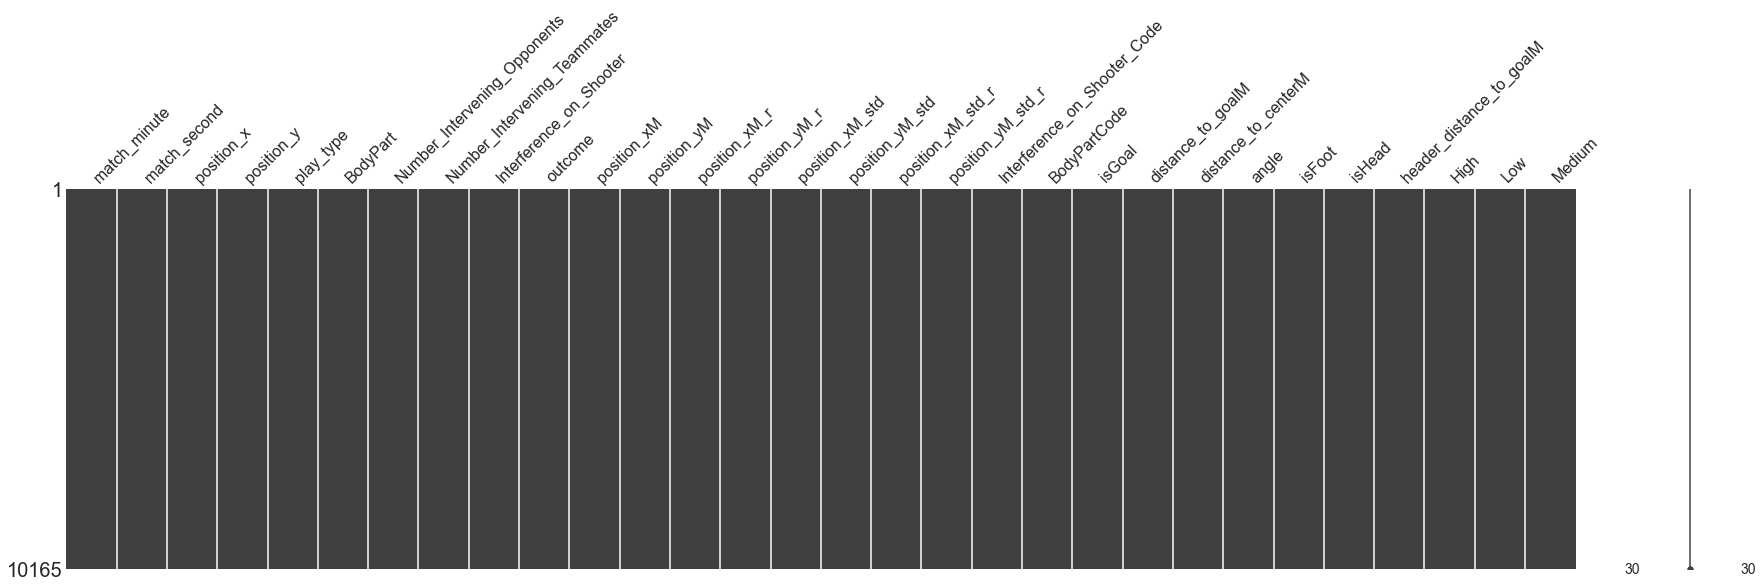

In [22]:
# Plot visualisation of the missing values for each feature of the engineered DataFrame, df_shots
msno.matrix(df_shots, figsize = (30, 7))

In [23]:
# Counts of missing values
null_value_stats = df_shots.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

The visualisation shows us very quickly that there are no missing values as they were treated in the first notebook, which even though XGBoost can cope well with sparse DataFrames, is good for modeling purposes. The notebook is now ready for modeling with [XGBoost](https://xgboost.readthedocs.io/en/latest/).

---

## <a id='#section7'>7. Initial Modeling</a>
First model created as a baseline for which interations of improvement are based.

### <a id='#section7.1'>7.1. Declare feature vector and target variable </a>

In [24]:
# Define features, as determined in the final Logistic Regression notebook
features = ['distance_to_goalM',
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
            'isFoot',
            'High',
            'Low',
            'header_distance_to_goalM'
           ]

X = df_shots[features]
y = df_shots['isGoal']

Now, let's take a look at feature vector (X) and target variable (y).

In [25]:
# Display feature vector
X.head()

,distance_to_goalM,angle,Number_Intervening_Opponents,Number_Intervening_Teammates,isFoot,High,Low,header_distance_to_goalM
0,23.168746,8.057879,3,1,1,0,1,0.000000
1,12.547625,42.642284,1,0,1,0,0,0.000000
2,21.484720,15.533201,3,0,1,0,0,0.000000
3,19.222875,29.625287,2,0,1,0,0,0.000000
4,8.944731,30.208981,3,0,0,0,0,8.944731


In [26]:
# Display target variable
y.head()

0    0
1    0
2    0
3    1
4    0
Name: isGoal, dtype: int64

### <a id='#section7.2'>7.2. Convert data to Dmatrix
Convert the dataset into an optimised data structure called **Dmatrix** that [XGBoost](https://xgboost.readthedocs.io/en/latest/) supports and gives it acclaimed performance and efficiency gains.

In [27]:
# Define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X, label=y)

#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest = xgb.DMatrix(X_test, label=y_test)

### <a id='#section7.3'>7.3. Split data into separate training and test set 

In [28]:
# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### <a id='#section7.4'>7.4. Correlation Matrix

<AxesSubplot:>

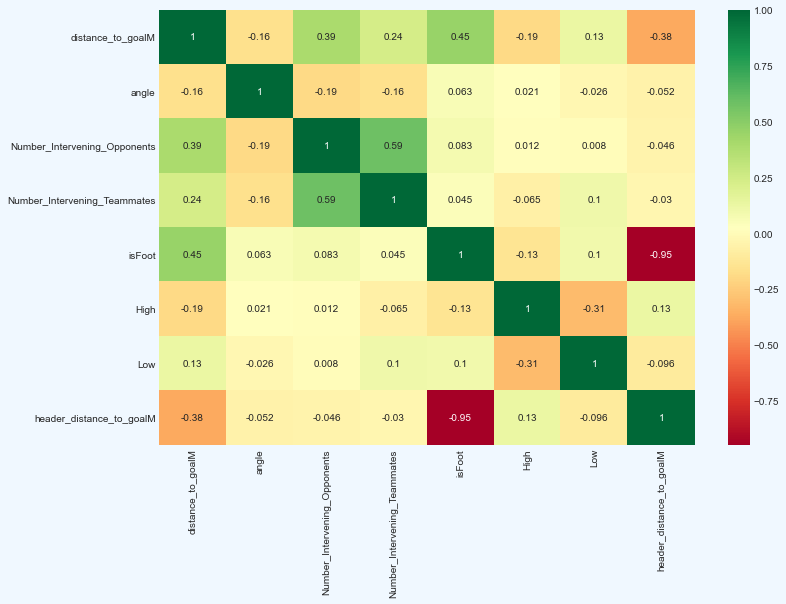

In [29]:
## Assign data to be used
df = X_train.corr()
top_corr_features = df.index

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)

## Seaborn heat map
sns.heatmap(df , 
            xticklabels=df.columns,
            yticklabels=df.columns,
            annot=True,
            cmap='RdYlGn',
           #vmin=0,
           #vmax=0.5
           )

### <a id='#section7.5'>7.5. Train the baseline XGBoost classifier
*    In order to train the XGBoost classifier, we need to know different parameters that XGBoost provides.
*    We will discuss these parameters in the next sections where they will be tuned
*    Now, its time to train the XGBoost Classifier.
*    We will proceed as follows:

In [30]:
# Declare initial parameters - will later be tuned      
params = {'max_depth': 6,
          'min_child_weight': 1,
          'eta': 0.3,
          'subsample': 1,
          'colsample_bytree': 1,
          'objective':'binary:logistic'
         }
    
# Instantiate the classifier 
xgb_clf = XGBClassifier(**params)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [31]:
# View the parameters of the xgb trained model
print(xgb_clf)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)


### <a id='#section7.6'>7.6. Predictions on Test Data and Log Loss

In [32]:
# Predict the probabilities of test set
y_pred = xgb_clf.predict_proba(X_test)

print(f"Log Loss of the initial XGBoost model: {sk_metrics.log_loss(y_test, y_pred):.5f}")
#print(f"AUC of the initial XGBoost model: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%")

Log Loss of the initial XGBoost model: 0.31302


In [33]:
# Convert the Probability Predictions array to a pandas DataFrame
df_predictions_initial = pd.DataFrame(y_pred, columns = ['prob_no_goal', 'prob_goal'])

# Join the Probability Predictions back onto the original test DataFrame
df_test_predictions_initial = pd.merge(X_test, df_predictions_initial, left_index=True, right_index=True)

# Display DataFrame
df_test_predictions_initial.head()

,distance_to_goalM,angle,Number_Intervening_Opponents,Number_Intervening_Teammates,isFoot,High,Low,header_distance_to_goalM,prob_no_goal,prob_goal
2232,25.220223,38.636838,2,0,1,0,0,0.000000,0.995641,0.004359
251,15.727027,14.732214,6,1,1,0,0,0.000000,0.476752,0.523248
1791,7.367172,24.004709,1,0,1,0,1,0.000000,0.998009,0.001991
1470,6.954845,14.608719,1,0,0,0,1,6.954845,0.998468,0.001532
33,24.050680,22.623755,3,0,1,0,1,0.000000,0.960804,0.039196


### <a id='#section7.7'>7.7. Visualise Initial XGBoost Test Predictions

In [34]:
# TO DO

### <a id='#section7.8'>7.8. Evaluation
We have the starting [XGBoost](https://xgboost.readthedocs.io/en/latest/) model, which is performing worse than the final Logistic Regression model, with a Log Loss on test set of 0.31302. To beat the performance of the existing Logistic Regression model, we're looking to reduce this Log Loss to ~0.280. Improvement of the Log Loss is done through k-fold Cross Validation and Hyperparameter Optimisation, conducted in the following sections.

## <a id='#section8'>8. k-fold Cross Validation using XGBoost
*    To build more robust models with XGBoost, it's important to always perform k-fold cross validation.
*    In this way, we ensure that the original training dataset is used for both training and validation.
*    Also, each entry is used for validation just once.
*    XGBoost supports k-fold cross validation using the `cv()` method.
*    In this method, we will specify several parameters which are as follows:
     +    `nfolds` - the number of cross-validation sets we want to build;
     +    `num_boost_round` - the number of trees to be built;
     +    `metrics` - the performance evaluation metrics to be considered during Cross Validation;
     +    `as_pandas` - used to return the results in a pandas DataFrame; and
     +    `early_stopping_rounds` - stops training of the model early if the hold-out metric does not improve for a given number of rounds.
     +    `seed` - This parameter is used for reproducibility of results.

We can use these parameters to build a k-fold cross-validation model by calling XGBoost's `CV()` method.

In [35]:
params = {'max_depth': 6,
          'min_child_weight': 1,
          'eta': 0.3,
          'subsample': 1,
          'colsample_bytree': 1,
          'objective':'binary:logistic'
         }

xgb_cv = cv(dtrain=data_dmatrix,
            params=params,
            nfold=10,
            num_boost_round=50,
            early_stopping_rounds=10,
            metrics='logloss',    #'auc',
            as_pandas=True,
            seed=42
           )

*    **xgb_cv** contains train and test auc metrics for each boosting round.
*    Let's preview **xgb_cv**:

In [36]:
# Display DataFrame
xgb_cv

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.520911,0.000595,0.524609,0.003459
1,0.426853,0.000733,0.433653,0.005843
2,0.369665,0.001090,0.378931,0.007355
3,0.332740,0.001079,0.345110,0.008575
4,0.308295,0.001253,0.323045,0.009148
5,0.291345,0.001524,0.309092,0.009534
6,0.279562,0.001786,0.300231,0.010257
7,0.270931,0.001561,0.294202,0.010293
8,0.264658,0.001702,0.290432,0.010368
9,0.259778,0.001440,0.288695,0.010168


## <a id='#section9'>9. Feature Importance with XGBoost
*    XGBoost provides a way to examine the importance of each feature in the original dataset within the model.
*    It involves counting the number of times each feature is split on across all boosting trees in the model.
*    Then we visualize the result as a bar graph, with the features ordered according to how many times they appear.
*    XGBoost has a `plot_importance()` function that helps us to achieve this task.
*    Then we can visualize the features that has been given the highest important score among all the features.
*    Thus XGBoost provides us a way to do feature selection.
*    We will proceed as follows:

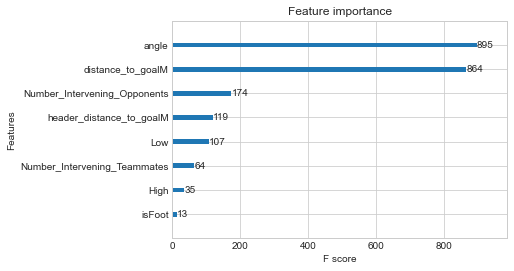

<Figure size 1440x1080 with 0 Axes>

In [37]:
xgb.plot_importance(xgb_clf,
                    ax=plt.gca()
                   )
plt.figure(figsize=(20, 15))
plt.show()

*    We can see that the feature `angle` has been given the highest importance score among all the features, closely followed by `distance_to_goalM`.
*    Based upon this importance score, we can select the features with highest importance score and discard the redundant ones.
*    Thus XGBoost also gives us a way to do feature selection.

## <a id='#section10'>10. Visualisation of the XGBoost Tree
Using `plot_tree`.

In [ ]:
plot_tree(xgb_clf, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(300, 150)
fig.savefig('tree_high_dpi', dpi=100)

In [ ]:
# Plot single tree
plt.figure(figsize=(25, 20))      # set plot size (denoted in inches)
plot_tree(xgb_clf,
          fontsize=10
         )
#plt.savefig('tree_high_dpi', dpi=100)
plt.show()

## <a id='#section11'>11. Hyperperameter Optimisation
Currently developed a simple baseline XGBoost model.
    
The next step is to tune these hyperparameters to improve the model and take full advantage of the XGBoost library.

### <a id='#section11.1'>11.1. What are hyperparameters?
*    Hyperparameters are certain values or weights that determine the learning process of an algorithm.
*    As stated earlier, XGBoost provides large range of hyperparameters. We can leverage the maximum power of XGBoost by tuning its hyperparameters.
*    The most powerful ML algorithm like XGBoost is famous for picking up patterns and regularities in the data by automatically tuning thousands of learnable parameters.
*    In tree-based models, like XGBoost the learnable parameters are the choice of decision variables at each node.
*    XGBoost is a very powerful algorithm. So, it will have more design decisions and hence large hyperparameters. These are parameters specified by hand to the algo and fixed throughout a training phase.
*    In tree-based models, hyperparameters include things like the maximum depth of the tree, the number of trees to grow, the number of variables to consider when building each tree, the minimum number of samples on a leaf and the fraction of observations used to build a tree.
*    Although we focus on optimizing XGBoost hyperparameters in this kernel, the concepts discussed in this kernel applies to any other advanced ML algorithm as well.

### <a id='#section11.2'>11.2. Hyperparameter types
*    Generally, the XGBoost hyperparameters have been divided into 4 categories. They are as follows:
     +    General parameters
     +    Booster parameters
     +    Learning task parameters
     +    Command line parameters

Before running a XGBoost model, we must set three types of parameters - **general parameters**, **booster parameters** and **task parameters**.

The fourth type of parameter are **command line parameters**. They are only used in the console version of XGBoost. So, we will skip these parameters and limit this notebook to the first three types of parameters.
    
The following sections goes into more detail about each of these parameters, but the most common ones to know about are:
*    `learning_rate`: step size shrinkage used to prevent overfitting. Range is [0,1];
*    `max_depth`: determines how deeply each tree is allowed to grow during any boosting round;
*    `subsample`: percentage of samples used per tree. Low value can lead to underfitting;
*    `colsample_bytree:` percentage of features used per tree. High value can lead to overfitting;
*    `n_estimators`: number of trees you want to build;
*    `objective`: determines the loss function to be used like reg:linear for regression problems, `reg:logistic` for classification problems with only decision, `binary:logistic` for classification problems with probability;
*    `gamma`: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners;
*    `alpha`: L1 regularization on leaf weights. A large value leads to more regularization; and
*    `lambda`: L2 regularization on leaf weights and is smoother than L1 regularization.
    
To read more about these parameters, see the official XGBoost parameter documentation [[link](http://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters)].

#### <a id='#section11.2.1'>11.2.1. General parameters
*    These parameters guide the overall functioning of the XGBoost model.
*    In this section, we will discuss three hyperparameters - booster, verbosity and nthread.
*    Visit the [XGBoost General Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters) official documentation for detailed discussion on general parameters.

##### <a id='#section11.2.1.1'>11.2.1.1. `booster`
*    **booster[default = gbtree]**
     +    booster parameter helps us to choose which booster to use.
     +    It helps us to select the type of model to run at each iteration.
     +    It has 3 options - **gbtree**, **gblinear**, or **dart**.
          -    **gbtree** and **dart** - use tree-based models, while
          -    **gblinear** uses linear models.

##### <a id='#section11.2.1.2'>11.2.1.2. `verbosity`
*    **verbosity[default = 1]**
     +    Verbosity of printing messages.
     +    Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug).

##### <a id='#section11.2.1.3'>11.2.1.3. `nthread`
*    **nthread [default = maximum number of threads available if not set]**
     +    This is number of parallel threads used to run XGBoost.
     +    This is used for parallel processing and number of cores in the system should be entered.
     +    If you wish to run on all cores, value should not be entered and algorithm will detect automatically.

There are other general parameters like **disable_default_eval_metric [default=0]**, **num_pbuffer [set automatically by XGBoost, no need to be set by user]** and **num_feature [set automatically by XGBoost, no need to be set by user]**.

So, these parameters are taken care by XGBoost algorithm itself. Hence, we will not discuss these further.

#### <a id='#section11.2.2'>11.2.2. Booster parameters
*    We have two types of boosters - **tree booster** and **linear booster**.
*    We will limit our discussion to **tree booster** because it always outperforms the **linear booster** and thus the later is rarely used.
*    Visit the [Parameters for Tree Booster](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster) official docs, for detailed discussion on booster parameters.

##### <a id='#section11.2.2.1'>11.2.2.1. `eta`
*    **eta [default=0.3, alias: learning_rate]**
     +    It is analogous to learning rate in GBM.
     +    It is the step size shrinkage used in update to prevent overfitting.
     +    After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
     +    It makes the model more robust by shrinking the weights on each step.
     +    range : [0,1]
     +    Typical final values : 0.01-0.2.

##### <a id='#section11.2.2.2'>11.2.2.2. `gamma`
*    **eta [default=0.3, alias: learning_rate]**
     +    It is analogous to learning rate in GBM.
     +    It is the step size shrinkage used in update to prevent overfitting.
     +    After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
     +    It makes the model more robust by shrinking the weights on each step.
     +    range : [0,1]
     +    Typical final values : 0.01-0.2.

##### <a id='#section11.2.2.3'>11.2.2.3. `max_depth`
*    **max_depth [default=6]**
     +    The maximum depth of a tree, same as GBM.
     +    It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
     +    Increasing this value will make the model more complex and more likely to overfit.
     +    The value 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth.
     +    We should be careful when setting large value of max_depth because XGBoost aggressively consumes memory when training a deep tree.
     +    range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist.
     +    Should be tuned using CV.
     +    Typical values: 3-10

##### <a id='#section11.2.2.4'>11.2.2.4. `min_child_weight`
*    **min_child_weight [default=1]**
     +    It defines the minimum sum of weights of all observations required in a child.
     +    This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
     +    It is used to control over-fitting.
     +    Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
     +    Too high values can lead to under-fitting.
     +    Hence, it should be tuned using CV.
     +    The larger min_child_weight is, the more conservative the algorithm will be.
     +    range: [0,∞]

##### <a id='#section11.2.2.5'>11.2.2.5. `max_delta_step`
*    **max_delta_step [default=0]**
     +    In maximum delta step we allow each tree’s weight estimation to be.
     +    If the value is set to 0, it means there is no constraint.
     +    If it is set to a positive value, it can help making the update step more conservative.
     +    Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
     +    Set it to value of 1-10 might help control the update.
     +    range: [0,∞]

##### <a id='#section11.2.2.6'>11.2.2.6. `subsample`
*    **subsample [default=1]**
     +    It denotes the fraction of observations to be randomly samples for each tree.
     +    Subsample ratio of the training instances.
     +    Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. - This will prevent overfitting.
     +    Subsampling will occur once in every boosting iteration.
     +    Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
     +    Typical values: 0.5-1
     +    range: (0,1]

##### <a id='#section11.2.2.7'>11.2.2.7. `colsample_bytree, colsample_bylevel, colsample_bynode`
*    **colsample_bytree, colsample_bylevel, colsample_bynode [default=1]**
     +    This is a family of parameters for subsampling of columns.
     +    All **colsample_by** parameters have a range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.
     +    **colsample_bytree** is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
     +    **colsample_bylevel** is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree.
     +    **colsample_bynode** is the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. Columns are subsampled from the set of columns chosen for the current level.
     +    **colsample_by** parameters work cumulatively. For instance, the combination **{'colsample_bytree':0.5, 'colsample_bylevel':0.5, 'colsample_bynode':0.5}** with 64 features will leave 8 features to choose from at each split.

##### <a id='#section11.2.2.8'>11.2.2.8. `lambda`
*    **lambda [default=1, alias: reg_lambda]**
     +    L2 regularization term on weights (analogous to Ridge regression).
     +    This is used to handle the regularization part of XGBoost.
     +    Increasing this value will make model more conservative.

##### <a id='#section11.2.2.9'>11.2.2.9. `alpha`
*    **alpha [default=0, alias: reg_alpha]**
     +    L1 regularization term on weights (analogous to Lasso regression).
     +    It can be used in case of very high dimensionality so that the algorithm runs faster when implemented.
     +    Increasing this value will make model more conservative.

##### <a id='#section11.2.2.10'>11.2.2.10. `tree_method`
*    **tree_method string [default= auto]**
     +    The tree construction algorithm used in XGBoost.
     +    XGBoost supports `approx`, `hist` and `gpu_hist` for distributed training. Experimental support for external memory is available for `approx` and `gpu_hist`.
     +    Choices: `auto`, `exact`, `approx`, `hist`, `gpu_hist`
          -    **auto**: Use heuristic to choose the fastest method.
               +    For small to medium dataset, exact greedy (exact) will be used.
               +    For very large dataset, approximate algorithm (approx) will be chosen.
               +    Because old behavior is always use exact greedy in single machine, user will get a message when approximate algorithm is chosen to notify this choice.
          -    **exact**: Exact greedy algorithm.
          -    **approx**: Approximate greedy algorithm using quantile sketch and gradient histogram.
          -    **hist**: Fast histogram optimized approximate greedy algorithm. It uses some performance improvements such as bins caching.
          -    **gpu_hist**: GPU implementation of hist algorithm.

##### <a id='#section11.2.2.11'>11.2.2.11. `scale_pos_weight`
*    **scale_pos_weight [default=1]**
     +    It controls the balance of positive and negative weights,
     +    It is useful for imbalanced classes.
     +    A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
     +    A typical value to consider: sum(negative instances) / sum(positive instances)

##### <a id='#section11.2.2.12'>11.2.2.12. `max_leaves`
*    **max_leaves [default=0]
     +    Maximum number of nodes to be added.
     +    Only relevant when grow_policy=lossguide is set.

There are other hyperparameters like `sketch_eps`, `updater`, `refresh_leaf`, `process_type`, `grow_policy`, `max_bin`, `predictor` and `num_parallel_tree`.

For detailed discussion of these hyperparameters, please visit [Parameters for Tree Booster](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster).

#### <a id='#section11.2.3'>11.2.3. Learning Task parameters

##### <a id='#section11.2.3.1'>11.2.3.1. `objective`
*    **objective [default=reg:squarederror]**
     +    It defines the loss function to be minimized. Most commonly used values are given below -
          -    **reg:squarederror**: regression with squared loss.
          -    **reg:squaredlogerror**: regression with squared log loss 1/2[log(pred+1)−log(label+1)]2. - All input labels are required to be greater than -1.
          -    **reg:logistic**: logistic regression
          -    **binary:logistic**: logistic regression for binary classification, output probability
          -    **binary:logitraw**: logistic regression for binary classification, output score before logistic transformation
          -    **binary:hinge**: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
          -    **multi:softmax**: set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)
          -    **multi:softprob**: same as softmax, but output a vector of ndata nclass, which can be further reshaped to ndata nclass matrix. The result contains predicted probability of each data point belonging to each class.

##### <a id='#section11.2.3.2'>11.2.3.2. `eval_metric`
*    **eval_metric [default according to objective]**
*    The metric to be used for validation data.
*    The default values are rmse for regression, error for classification and mean average precision for ranking.
*    We can add multiple evaluation metrics.
*    Python users must pass the metrices as list of parameters pairs instead of map.
*    The most common values are given below:
     +    **rmse**: [root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
     +    **mae**: [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error)
     +    **logloss**: [negative log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood)
     +    **error**: Binary classification error rate (0.5 threshold). It is calculated as #(wrong cases)/#(all cases). For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as      +    positive instances, and the others as negative instances.
     +    **merror**: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).
     +    **mlogloss**: [Multiclass logloss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)
     +    **auc**: [Area under the curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_curve)
     +    **aucpr**: [Area under the PR curve](https://en.wikipedia.org/wiki/Precision_and_recall)

##### <a id='#section11.2.3.3'>11.2.3.3. `seed`
*    **seed [default=0]**
     +    The random number seed.
     +    It can be used for generating reproducible results and also for parameter tuning.

### <a id='#section11.3'>11.3. Optimisation
Parameters can be optimised in a number of ways, two of which are discussed in the following sections:
*    Bayesian Optimisation with HYPEROPT ([section 11.3.1](#section11.3.1));
*    Random Search ([section 11.3.2](#section11.3.2)); and
*    Grid Search ([section 11.3.3](#section11.3.3)).

#### <a id='#section11.3.1'>11.3.1. Bayesian Optimisation with HYPEROPT
*    **Bayesian optimisation** is optimisation or finding the best parameter for a machine learning or deep learning algorithm.
*    **Optimization** is the process of finding a minimum of cost function , that determines an overall better performance of a model on both train-set and test-set.
*    In this process, we train the model with various possible range of parameters until a best fit model is obtained.
*    **Hyperparameter tuning** helps in determining the optimal tuned parameters and return the best fit model, which is the best practice to follow while building an ML or DL model.
*    In this section, we discuss one of the most accurate and successful hyperparameter tuning method, which is **Bayesian Optimisation with HYPEROPT**.

##### <a id='#section11.3.1.1'>11.3.1.1. What is HYPEROPT
*    HYPEROPT is a powerful python library that search through an hyperparameter space of values and find the best possible values that yield the minimum of the loss function.
*    Bayesian Optimization technique uses Hyperopt to tune the model hyperparameters. Hyperopt is a Python library which is used to tune model hyperparameters.
*    More information on Hyperopt can be found at the following [[link](https://hyperopt.github.io/hyperopt/?source=post_page)].

##### <a id='#section11.3.1.2'>11.3.1.2. Four parts of Optimisation Process
*    The optimization process consists of 4 parts which are as follows:<br>
     **1.    Initialize domain space**
*    The domain space is the input values over which we want to search.<br>
     **2.    Define objective function**
*    The objective function can be any function which returns a real value that we want to minimize. In this case, we want to minimize the validation error of a machine learning model with respect to the hyperparameters. If the real value is accuracy, then we want to maximize it. Then the function should return the negative of that metric.<br>
     **3.    Optimization algorithm**
*    It is the method used to construct the surrogate objective function and choose the next values to evaluate.<br>
     **4.    Results**
*    Results are score or value pairs that the algorithm uses to build the model.

##### <a id='#section11.3.1.3'>11.3.1.3. Bayesian Optimisation implementation

######  Initialise domain space for range of values 

In [ ]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': 180,
       'seed': 0
      }

The available hyperopt optimization algorithms are:
*    **hp.choice(label, options)** — Returns one of the options, which should be a list or tuple.
*    **hp.randint(label, upper)** — Returns a random integer between the range [0, upper).
*    **hp.uniform(label, low, high)** — Returns a value uniformly between low and high.
*    **hp.quniform(label, low, high, q)** — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.
*    **hp.normal(label, mean, std)** — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

######  Define objective function
See: https://mlwhiz.com/blog/2019/10/10/hyperopt2/

In [ ]:
"""
# Define the objective function
def objective(space):
    clf=xgb.XGBClassifier(n_estimators =space['n_estimators'],
                          max_depth = int(space['max_depth']),
                          gamma = space['gamma'],
                          reg_alpha = int(space['reg_alpha']),
                          min_child_weight=int(space['min_child_weight']),
                          colsample_bytree=int(space['colsample_bytree'])
                         )
    
    evaluation = [(X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train,
            y_train,
            eval_set=evaluation,
            eval_metric='logloss',    #'auc'
            early_stopping_rounds=10,
            verbose=False
           )
    

    #pred = clf.predict(X_test)
    pred = clf.predict_proba(X_test)
    logloss = log_loss(y_test, pred)
    print(f'Log Loss of the HYPEROPT Optimisation XGBoost model: {logloss:.5f}')
    return {f'loss: -{logloss} status: STATUS_OK'}
"""

In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

###### Optimisation algorithm

In [ ]:
from hyperopt import Trials
trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials
                       )

*    Here **best_hyperparams** gives us the optimal parameters that best fit model and better loss function value.
*    **trial**s is an object that contains or stores all the relevant information such as hyperparameter, loss-functions for each set of parameters that the model has been trained.
*    ‘**fmin**’ is an optimization function that minimizes the loss function and takes in 4 inputs - fn, space, algo and max_evals.
*    Algorithm used is **tpe.suggest**.

###### Print results

In [ ]:
print(f'The best hyperparameters as determined by HYPEROPT are: \n {best_hyperparams}')

#### <a id='#section11.3.2'>11.3.2. Random Search

In [ ]:
# A parameter grid for XGBoost
params = {'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5]
         }

In [ ]:
xgb_clf = XGBClassifier(learning_rate=0.02,
                        n_estimators=600,
                        objective='binary:logistic',
                        silent=True,
                        nthread=1
                       )

In [ ]:
folds=3
param_comb=5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(xgb_clf,
                                   param_distributions=params,
                                   n_iter=param_comb,
                                   scoring='neg_log_loss',    # for all scoring metrics see sorted(sklearn.metrics.SCORERS.keys()), link: https://scikit-learn.org/stable/modules/model_evaluation.html
                                   n_jobs=4,
                                   cv=skf.split(X_train, y_train),
                                   verbose=3,
                                   random_state=42
                                  )

# Run
start_time = timer(None)
random_search.fit(X_train, y_train)
timer(start_time)

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

In [ ]:
y_test_fit = random_search.predict_proba(y_test)
df_results_random_search = pd.DataFrame(data={'id':test_df['id'], 'target':y_test_fit[:,1]})
#df_results_random_search.to_csv('...csv', index=False)

#### <a id='#section11.3.3'>11.3.3. Grid Search

In [45]:
# Declare parameters 
params = {'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5],
          'objective':['binary:logistic']
         }

In [46]:
xgb_clf = XGBClassifier(learning_rate=0.02,
                        n_estimators=600,
                        objective='binary:logistic',
                        silent=True,
                        nthread=1
                       )

In [47]:
folds=10
param_comb=5

skf = StratifiedKFold(n_splits=folds,
                      shuffle=True,
                      random_state=42
                     )

grid = GridSearchCV(estimator=xgb_clf,
                    param_grid=params,
                    scoring='neg_log_loss',
                    n_jobs=4,
                    cv=skf.split(X_train, y_train),
                    verbose=3
                   )

# Run
start_time = timer(None)
grid.fit(X_train, y_train)
timer(start_time)

Fitting 10 folds for each of 405 candidates, totalling 4050 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   47.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  8.5min
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed: 11.8min
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed: 16.1min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed: 21.2min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 27.7min
[Parallel(n_jobs=4)]: Done 3864 tasks      | elapsed: 34.8min
[Parallel(n_jobs=4)]: Done 4050 out of 4050 | elapsed: 36.9min finished



 Time taken: 0 hours 36 minutes and 57.98 seconds.


In [48]:
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)
df_results_grid = pd.DataFrame(grid.cv_results_)
#df_results.to_csv('...csv', index=False)


 All results:
{'mean_fit_time': array([1.3418781 , 1.31005177, 1.36718457, 1.45572393, 1.454352  ,
       1.37052956, 1.56167564, 1.43805261, 1.31908159, 1.76223562,
       1.67280974, 1.63670011, 1.77255685, 1.71860421, 1.63942032,
       1.77367494, 1.75209167, 1.75605588, 2.95280702, 2.74986479,
       2.08155735, 2.13296692, 2.05575907, 2.14769018, 2.38715837,
       2.08761475, 1.87370288, 1.45678041, 1.47322657, 1.41180944,
       1.62130322, 1.47826326, 1.30192428, 1.38983588, 1.47404051,
       1.42111788, 1.91576049, 1.78741152, 1.61063197, 1.7049226 ,
       1.67965415, 1.67616758, 1.90577941, 1.8008404 , 1.62429039,
       2.08793833, 2.00812762, 1.84609025, 2.02361946, 1.98783731,
       1.89660201, 2.02891181, 1.96665137, 1.83783171, 1.48844554,
       1.52135162, 1.36757953, 1.49909456, 1.43692868, 1.24903405,
       1.5063132 , 1.56712363, 1.53276327, 2.00454192, 1.85359302,
       1.71411843, 1.80610268, 1.74658751, 1.61326423, 1.83072507,
       1.77305732, 1.6737602 

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

 Best score:
-1.5623230327237603

 Best parameters:
{'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 1, 'objective': 'binary:logistic', 'subsample': 0.8}


In [49]:
y_pred = grid.best_estimator_.predict_proba(X_test)
#df_results_grid = pd.DataFrame(data={'id':test_df['id'], 'target':y_test[:,1]})
#df_results_grid.to_csv('....csv', index=False)

print(f'Log loss on test set using parameters derived by Grid Search: {sk_metrics.log_loss(y_test, y_pred):.5f}')
#print(f"AUC on test set: {sk_metrics.roc_auc_score(y_test, y_pred)*100:.2f}%")

Log loss on test set using parameters derived by Grid Search: 0.28600


## <a id='#section12'>12. Final Optimised XGBoost Model</a>

In [50]:
# Take the parameters derived from Grid Search
print(f'The best hyperparameters as determined by Grid Search are: \n {grid.best_params_}')
#grid.best_params_

The best hyperparameters as determined by Grid Search are: 
 {'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 1, 'objective': 'binary:logistic', 'subsample': 0.8}


In [54]:
# Declare parameters
params = {'colsample_bytree': 1.0,
          'gamma': 5,
          'max_depth': 3,
          'min_child_weight': 1,
          'objective': 'binary:logistic',
          'subsample': 0.8
         }
          
# Instantiate the classifier 
xgb_clf_final = XGBClassifier(**params)

# Fit the classifier to the training data
xgb_clf_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

In [55]:
# Predict the probabilities of test set
y_pred_final = xgb_clf_final.predict_proba(X_test)

print(f'Log Loss of the final XGBoost model: {sk_metrics.log_loss(y_test, y_pred_final):.5f}')
#print(f"AUC on test set: {sk_metrics.roc_auc_score(y_test, y_pred_final)*100:.2f}%")

Log Loss of the final XGBoost model: 0.29018


In [56]:
# Convert the Probability Predictions array to a pandas DataFrame
df_predictions_final = pd.DataFrame(y_pred_final, columns=['prob_no_goal', 'prob_goal'])

# Join the Probability Predictions back onto the original test DataFrame
df_test_predictions_final = pd.merge(X_test, df_predictions_final, left_index=True, right_index=True)

# Display DataFrame
df_test_predictions_final.head()

,distance_to_goalM,angle,Number_Intervening_Opponents,Number_Intervening_Teammates,isFoot,High,Low,header_distance_to_goalM,prob_no_goal,prob_goal
2232,25.220223,38.636838,2,0,1,0,0,0.000000,0.968908,0.031092
251,15.727027,14.732214,6,1,1,0,0,0.000000,0.433905,0.566095
1791,7.367172,24.004709,1,0,1,0,1,0.000000,0.991282,0.008718
1470,6.954845,14.608719,1,0,0,0,1,6.954845,0.983665,0.016335
33,24.050680,22.623755,3,0,1,0,1,0.000000,0.933416,0.066584


---

## <a id='#section13'>13. Performance Comparison of XGBoost with Logistic Regression</a>

Final reported Log Loss for each model:
- Logistic Regression: 0.28924
- XGBoost: 0.28600

This is a reduction of 0.00324 when using XGBoost.

## <a id='#section14'>14. Assessment of the Performance of the Teams in Game 2 of the Metrica Sports Shot Data
The next stage of this analysis to take the Chance Quality Model derived and apply it to the DataFrame of identified shots from game 2 of the sample Metrica Sports data. to determine which team deserved to win the game, based solely on the quality of chances that each team created.

### <a id='#section14.1'>14.1. Apply the Trained Chance Quality Model from XGBoost to the Metrica Sports Data

##### Import Metrica Sports Shots data for game 2

In [65]:
# Read data directory
print(glob.glob(os.path.join(data_dir_metrica, 'engineered/*')))

['../../data/metrica-sports/engineered/game_2_shots_with_xg_lr_xgb.csv', '../../data/metrica-sports/engineered/game_2_shots.csv', '../../data/metrica-sports/engineered/archive', '../../data/metrica-sports/engineered/submitted', '../../data/metrica-sports/engineered/game_2_shots_with_xg.csv']


In [66]:
# Read in exported Metrica Sports game 2 shots CSV as a pandas DataFrame
df_metrica = pd.read_csv(os.path.join(data_dir_metrica, 'engineered', 'game_2_shots_with_xg.csv'))

In [67]:
# Embed video of the 24 shots in game 2 of the Metrica Sports sample data
Video('../../../../../video/fig/metrica-sports/tracking_shots_all.mp4', width=770, height=530)

In [68]:
# Rename xG column derived in previous model using Logistic Regression (later compared to value derived from XGBoost) and drop previous prediction columns
df_metrica = (df_metrica
                  .rename(columns={'xG': 'xG_LR'})
                  .drop(['prob_no_goal', 'prob_goal'], axis=1)
             )

# Display DataFrame
df_metrica.head()

,match_minute,match_second,outcome,position_xM,position_yM,position_xM_r,position_yM_r,distance_to_goalM,angle,distance_to_centerM,isGoal,BodyPart,isFoot,isHead,team,period,start_frame,end_frame,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,interference_on_shooter_number_players,subtype,isPenalty,isDirectFK,xG_LR
0,2,57,Missed,39.22,18.36,-39.22,-18.36,22.956001,53.110135,18.36,0,Foot,1,0,Home,1,4419,4443,3,0,Medium,1,OFF TARGET-OUT,0,0,0.023068
1,8,8,Goal,47.70,-3.40,-47.70,3.40,6.296825,32.680555,3.40,1,Foot,1,0,Home,1,12202,12212,1,0,High,2,ON TARGET-GOAL,0,0,0.234639
2,10,59,Saved,41.34,11.56,-41.34,-11.56,16.419172,44.753250,11.56,0,Foot,1,0,Home,1,16484,16499,2,0,Medium,1,ON TARGET-SAVED,0,0,0.091269
3,12,21,Blocked,31.80,10.20,-31.80,-10.20,23.526156,25.693700,10.20,0,Foot,1,0,Away,1,18515,18520,1,1,Low,0,BLOCKED,0,0,0.083353
4,18,14,Missed,43.46,-6.12,-43.46,6.12,11.334284,32.680555,6.12,0,Head,0,1,Home,1,27345,27360,1,1,High,2,BLOCKED,0,0,0.037415


##### Subset Metrica Sports data to be compatible with trained Chance Quality Model

In [69]:
# Define function to transform both the Chance Quality model and the Metrica Sports data to be compatible with trained Chance Quality Model
def transformation_metrica(df):
    """
    Function performs all transformation steps that took place in the first CQM notebook
    """
    
    df = df.copy()
    
    # Compute the distance to the center - distance_to_centerM
    df['distance_to_centerM'] = np.abs(df['position_yM'])

    # Compute header distance to goal
    df['header_distance_to_goalM'] = df['isHead'] * df['distance_to_goalM']
    
    # One-hot encode the Interference on the Shooter
    
    ## One-hot encoding
    df_dummy_interference_on_shooter = pd.get_dummies(df['Interference_on_Shooter'])
    
    # Attach separate columns back onto the dataset
    df = pd.concat([df, df_dummy_interference_on_shooter], axis=1)
    
    return df

In [73]:
# Transform and subset Metrica Sports data to be compatible with trained Chance Quality Model

## Transform data
df_metrica_trans = transformation_metrica(df_metrica)

## Define Features
features = ['distance_to_goalM',
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
            'isFoot',
            'High',     # 'Interference_on_Shooter'
            'Low',       # 'Interference_on_Shooter'
            'header_distance_to_goalM'
           ]

## Transform Metrica Sports data 
df_metrica_trans = df_metrica_trans[features]

# Display DataFrame
df_metrica_trans.head()

,distance_to_goalM,angle,Number_Intervening_Opponents,Number_Intervening_Teammates,isFoot,High,Low,header_distance_to_goalM
0,22.956001,53.110135,3,0,1,0,0,0.000000
1,6.296825,32.680555,1,0,1,1,0,0.000000
2,16.419172,44.753250,2,0,1,0,0,0.000000
3,23.526156,25.693700,1,1,1,0,1,0.000000
4,11.334284,32.680555,1,1,0,1,0,11.334284


##### Probability Predictions

In [71]:
# Predict the probabilities of MetricaSports shot data
y_pred_metrica = xgb_clf_final.predict_proba(df_metrica_trans[features])

In [89]:
# Convert the Probability Predictions array to a pandas DataFrame
df_metrica_predictions = pd.DataFrame(y_pred_metrica, columns=['prob_no_goal', 'prob_goal'])

# Join the Probability Predictions back onto the original test DataFrame
df_metrica_predictions_final = pd.merge(df_metrica, df_metrica_predictions, left_index=True, right_index=True)

# Create xG column and assign all penalties not accounted for in trained model an xG of 0.75
df_metrica_xg = df_metrica_predictions_final
df_metrica_xg['xG'] = df_metrica_xg['prob_goal']
df_metrica_xg['xG'] = np.where(df_metrica_xg['isPenalty'] == 1, 0.76, df_metrica_xg['xG'])

# Display DataFrame
df_metrica_xg.head()

,match_minute,match_second,outcome,position_xM,position_yM,position_xM_r,position_yM_r,distance_to_goalM,angle,distance_to_centerM,isGoal,BodyPart,isFoot,isHead,team,period,start_frame,end_frame,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,interference_on_shooter_number_players,subtype,isPenalty,isDirectFK,xG_LR,prob_no_goal,prob_goal,xG
0,2,57,Missed,39.22,18.36,-39.22,-18.36,22.956001,53.110135,18.36,0,Foot,1,0,Home,1,4419,4443,3,0,Medium,1,OFF TARGET-OUT,0,0,0.023068,0.990887,0.009113,0.009113
1,8,8,Goal,47.70,-3.40,-47.70,3.40,6.296825,32.680555,3.40,1,Foot,1,0,Home,1,12202,12212,1,0,High,2,ON TARGET-GOAL,0,0,0.234639,0.790311,0.209689,0.209689
2,10,59,Saved,41.34,11.56,-41.34,-11.56,16.419172,44.753250,11.56,0,Foot,1,0,Home,1,16484,16499,2,0,Medium,1,ON TARGET-SAVED,0,0,0.091269,0.932397,0.067603,0.067603
3,12,21,Blocked,31.80,10.20,-31.80,-10.20,23.526156,25.693700,10.20,0,Foot,1,0,Away,1,18515,18520,1,1,Low,0,BLOCKED,0,0,0.083353,0.918703,0.081297,0.081297
4,18,14,Missed,43.46,-6.12,-43.46,6.12,11.334284,32.680555,6.12,0,Head,0,1,Home,1,27345,27360,1,1,High,2,BLOCKED,0,0,0.037415,0.940236,0.059764,0.059764


### <a id='#section14.2'>14.2. Assessment of the Performance of the Teams in Game 2 of the Metrica Sports Shot Data

##### xG Race Chart of XGBoost model predictions

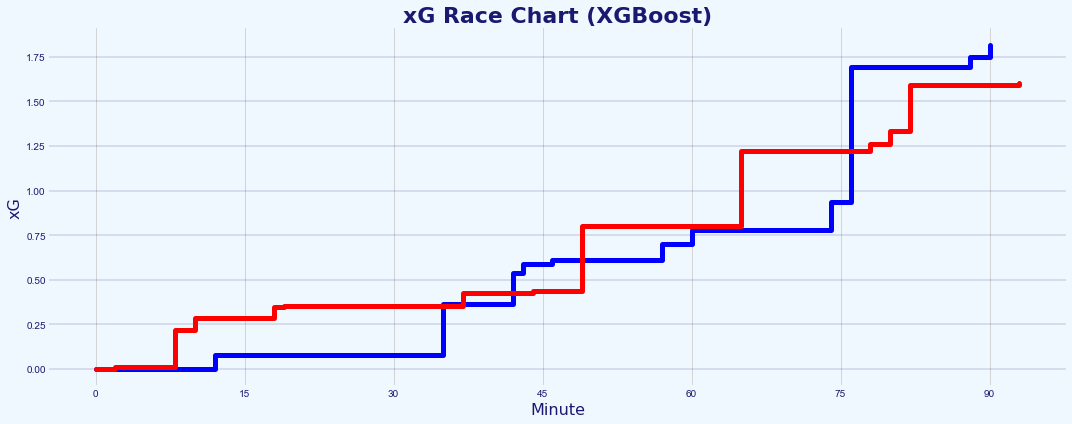

In [90]:
# Create xG Race Chart of XGBoost model with revised xG for penalties

## Assign DataFrame
df = df_metrica_xg

## Create four lists to plot the different xG values - home, away, xG, and minutes. We start these with zero so our charts will start at 0
a_xG = [0]
h_xG = [0]
a_min = [0]
h_min = [0]

## Define team names from the DataFrame
hteam = 'Home'
ateam = 'Away'

## For loop to append the xG and minute for both the Home and Away teams
for x in range(len(df['xG'])):
    if df['team'][x]==ateam:
        a_xG.append(df['xG'][x])
        a_min.append(df['match_minute'][x])
    if df['team'][x]==hteam:
        h_xG.append(df['xG'][x])
        h_min.append(df['match_minute'][x])
        
## Function we use to make the xG values be cumulative rather than single shot values. Foes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

## Apply defned nums_cumulative_sum function to the home and away xG lists
a_cumulative = nums_cumulative_sum(a_xG)
h_cumulative = nums_cumulative_sum(h_xG)

## Find the total xG. Create a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 6))
fig.set_facecolor(background)
ax.patch.set_facecolor(background)

# Set up our base layer
mpl.rcParams['xtick.color'] = 'midnightblue'
mpl.rcParams['ytick.color'] = 'midnightblue'

## Create xG Race Chart
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.xlabel('Minute', fontfamily='DejaVu Sans', color='midnightblue', fontsize=16)
plt.ylabel('xG', fontfamily='DejaVu Sans', color='midnightblue', fontsize=16)

# Plot the step graphs
ax.step(x=a_min, y=a_cumulative, color='blue', label=ateam, linewidth=5, where='post')
ax.step(x=h_min, y=h_cumulative, color='red', label=ateam, linewidth=5, where='post')

## Set Gridlines 
ax.grid(linewidth=0.25, color='midnightblue', axis='y', zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)

## Set title
ax.set_title('xG Race Chart (XGBoost)',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_shots_dir + '/metrica_shots_race_chart_xg_xgboost.png'):
    plt.savefig(fig_shots_dir + '/metrica_shots_race_chart_xg_xgboost.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

##### xG Race Chart of Logistic Regression model predictions (derived in the previous CQM notebook)

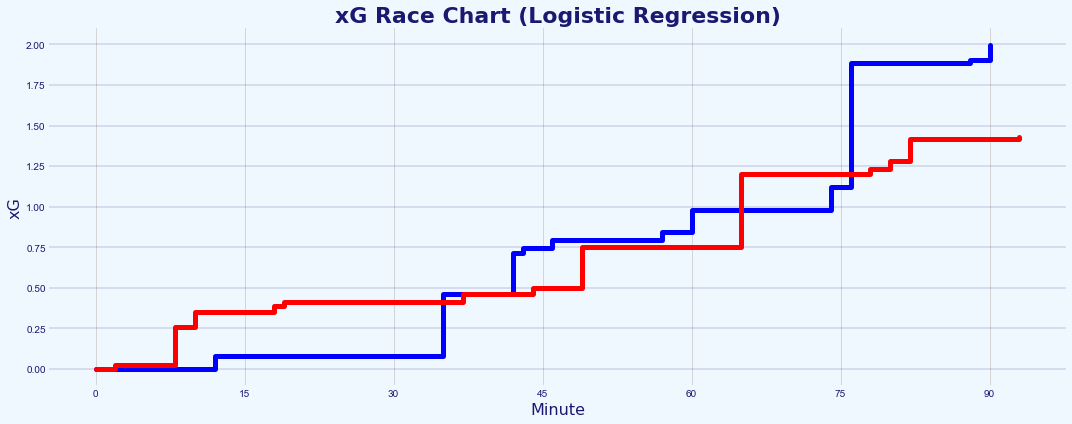

In [91]:
# Create xG Race Chart of Logistic Regression model with revised xG for penalties

## Assign DataFrame
df = df_metrica_xg

## Create four lists to plot the different xG values - home, away, xG, and minutes. We start these with zero so our charts will start at 0
a_xG = [0]
h_xG = [0]
a_min = [0]
h_min = [0]

## Define team names from the DataFrame
hteam = 'Home'
ateam = 'Away'

## For loop to append the xG and minute for both the Home and Away teams
for x in range(len(df['xG_LR'])):
    if df['team'][x]==ateam:
        a_xG.append(df['xG_LR'][x])
        a_min.append(df['match_minute'][x])
    if df['team'][x]==hteam:
        h_xG.append(df['xG_LR'][x])
        h_min.append(df['match_minute'][x])
        
## Function we use to make the xG values be cumulative rather than single shot values. Foes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

## Apply defned nums_cumulative_sum function to the home and away xG lists
a_cumulative = nums_cumulative_sum(a_xG)
h_cumulative = nums_cumulative_sum(h_xG)

## Find the total xG. Create a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 6))
fig.set_facecolor(background)
ax.patch.set_facecolor(background)

# Set up our base layer
mpl.rcParams['xtick.color'] = 'midnightblue'
mpl.rcParams['ytick.color'] = 'midnightblue'

## Create xG Race Chart
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.xlabel('Minute', fontfamily='DejaVu Sans', color='midnightblue', fontsize=16)
plt.ylabel('xG', fontfamily='DejaVu Sans', color='midnightblue', fontsize=16)

# Plot the step graphs
ax.step(x=a_min, y=a_cumulative, color='blue', label=ateam, linewidth=5, where='post')
ax.step(x=h_min, y=h_cumulative, color='red', label=ateam, linewidth=5, where='post')

## Set Gridlines 
ax.grid(linewidth=0.25, color='midnightblue', axis='y', zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)

## Set title
ax.set_title('xG Race Chart (Logistic Regression)',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_shots_dir + '/metrica_shots_race_chart_xg_lr.png'):
    plt.savefig(fig_shots_dir + '/metrica_shots_race_chart_xg_lr.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

Comparison of the xG Race Charts for both the XGBoost and Logistic Regression Chance Quality Models both predict that, the Away team (blue) is the team that accumlates the greatest amount of xG during the course of the 90 minutes. However, in the XGBoost model, the gap is much narrower, further confirming that these basic models need to be tested with more data and analysed more thoroughly.

### <a id='#section14.3'>14.3. Comparison of the XGBoost and Logistic Regression Predictions

In [93]:
# Rename xG column derived from XGBoost (used to compared to previous calculated xG value in Logistic Regression model) and create a variance column
df_metrica_xg = df_metrica_xg.rename(columns={'xG': 'xG_XGB'})

In [94]:
# Compare the two xG columns of the LR and XGB models

## Difference in xG between LR and XGB models
df_metrica_xg['diff_xG'] = df_metrica_xg['xG_LR'] - df_metrica_xg['xG_XGB']

## Percentage variance in xG between LR and XGB models
df_metrica_xg['percentage_variance_xG'] = (((df_metrica_xg['xG_XGB'] - df_metrica_xg['xG_LR']) / df_metrica_xg['xG_LR'])*100).round(2)

# Display DataFrame
df_metrica_xg

,match_minute,match_second,outcome,position_xM,position_yM,position_xM_r,position_yM_r,distance_to_goalM,angle,distance_to_centerM,isGoal,BodyPart,isFoot,isHead,team,period,start_frame,end_frame,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,interference_on_shooter_number_players,subtype,isPenalty,isDirectFK,xG_LR,prob_no_goal,prob_goal,xG_XGB,diff_xG,percentage_variance_xG
0,2,57,Missed,39.22,18.36,-39.22,-18.36,22.956001,53.110135,18.36,0,Foot,1,0,Home,1,4419,4443,3,0,Medium,1,OFF TARGET-OUT,0,0,0.023068,0.990887,0.009113,0.009113,1.395438e-02,-60.49
1,8,8,Goal,47.70,-3.40,-47.70,3.40,6.296825,32.680555,3.40,1,Foot,1,0,Home,1,12202,12212,1,0,High,2,ON TARGET-GOAL,0,0,0.234639,0.790311,0.209689,0.209689,2.494988e-02,-10.63
2,10,59,Saved,41.34,11.56,-41.34,-11.56,16.419172,44.753250,11.56,0,Foot,1,0,Home,1,16484,16499,2,0,Medium,1,ON TARGET-SAVED,0,0,0.091269,0.932397,0.067603,0.067603,2.366666e-02,-25.93
3,12,21,Blocked,31.80,10.20,-31.80,-10.20,23.526156,25.693700,10.20,0,Foot,1,0,Away,1,18515,18520,1,1,Low,0,BLOCKED,0,0,0.083353,0.918703,0.081297,0.081297,2.056093e-03,-2.47
4,18,14,Missed,43.46,-6.12,-43.46,6.12,11.334284,32.680555,6.12,0,Head,0,1,Home,1,27345,27360,1,1,High,2,BLOCKED,0,0,0.037415,0.940236,0.059764,0.059764,-2.234836e-02,59.73
5,19,50,Saved,31.80,-13.60,-31.80,13.60,25.187298,32.680555,13.60,0,Foot,1,0,Home,1,29754,29777,3,1,Low,0,HEAD-OFF TARGET-OUT,0,0,0.027432,0.993465,0.006535,0.006535,2.089644e-02,-76.18
6,35,22,Goal,44.52,2.72,-44.52,-2.72,8.905549,17.783888,2.72,1,Foot,1,0,Away,1,53049,53075,1,0,Medium,1,ON TARGET-GOAL,0,0,0.378579,0.718295,0.281705,0.281705,9.687353e-02,-25.59
7,37,23,Missed,42.40,6.12,-42.40,-6.12,12.239869,30.000353,6.12,0,Head,0,1,Home,1,56079,56131,2,0,Low,0,HEAD-OFF TARGET-OUT,0,0,0.051632,0.924155,0.075845,0.075845,-2.421259e-02,46.89
8,42,14,Missed,45.58,0.68,-45.58,-0.68,7.451094,5.236200,0.68,0,Head,0,1,Away,1,63362,63372,1,0,Medium,1,OFF TARGET-HEAD-OUT,0,0,0.252221,0.824079,0.175921,0.175921,7.630005e-02,-30.25
9,43,11,Saved,28.62,-3.40,-28.62,3.40,24.615938,7.939183,3.40,0,Foot,1,0,Away,1,64772,64799,3,1,Medium,1,ON TARGET-SAVED,0,0,0.033134,0.950095,0.049905,0.049905,-1.677090e-02,50.62


In [97]:
# Description of the selected columns
df_metrica_xg[['xG_LR', 'xG_XGB', 'diff_xG', 'percentage_variance_xG']].describe()

,xG_LR,xG_XGB,diff_xG,percentage_variance_xG
count,24.000000,24.000000,24.000000,24.000000
mean,0.142752,0.142561,0.000190,7.654583
std,0.176212,0.173786,0.049089,56.770089
min,0.009366,0.006535,-0.125309,-76.180000
25%,0.034485,0.047874,-0.020498,-27.010000
50%,0.068916,0.075103,0.001731,-4.740000
75%,0.166278,0.184363,0.024659,47.505000
max,0.760000,0.760000,0.096874,158.680000


The `diff_xG` and `percentage_variance_xG` show the difference between the predictions made by the Logistic Regression and XGBoost models. 8 of the 24 shots have a variance greater than 50%. I won't go into too much detail here about these variances at this stage (I might come back to this later on), but to summarise, these simple models show that much more testing that is required before the predictions can be confirmed as robust.

### <a id='#section14.4'>14.4. Export the Final Dataset

In [95]:
# Export the final dataset
df_metrica_xg.to_csv(os.path.join(data_dir_metrica, 'engineered', 'game_2_shots_with_xg_lr_xgb.csv'), index=None, header=True)

## <a id='#section15'>15. Summary</a>
To summarise, this notebook builds upon the initial Chance Quality Model created using Logistic Regression from shots data, this time using XGBoost. This notebook then compares the variances between the two models

The steps to create this model can be summarised as the following:
1.     Set up the notebook for an environment in which to apply the XGBoost know Machine Learning algorithm to a dataset of shots data.
2.    Re-explained the challenge to create a Chance Quality Model and defined the key proxy in which to determine this - <b>Expected Goals</b>.
3.     Imported the provided CSV data file imported as a pandas DataFrame and conducted a basic Exploratory Data Analysis.
4.     Introduction to XGBoost.
5.     Explanation of the difference between Bagging Vs. Boosting.
6.     Theory Behind the XGBoost Algorithm.
7.     Imported the engineered shots dataset created in the first Chance Quality Model notebook.
8.     Created an initial model using the data and features that were immediately available from the starting data, before any model optimisation, to determine a baseline figure for the model. This data was split into a training and a test set, which were kept separate during the entire modelling process and the test data was never incorporated into the training data.
9.     k-fold Cross Validation using XGBoost.
10.    Feature Importance with XGBoost.
11.    Visualisation of XGBoost Tree.
12.    Hyperparameter Optimisation.
13.    Final Optimised XGBoost Model - training of the final model using the parameters found via Grid Search.
14.    Performance comparison of XGBoost with Logistic Regression - final XGBoost model has a resulting Log Loss of 0.28600, where the final Logistic Regression had a Log Loss of 0.28924 - reduction of 0.00324.
15.    Assessment of the teams performance in the Metrica Sports data to determine who deserved to win the game, based solely on the quality of chances that each team created - the <b>Away</b> (blue) team. The predicted xG values for the shots determined by the two Chance Quality Models were compared.

---

## <a id='#section16'>16. Next Steps</a>

Proposals and ideas for further work can be divided into two sections - Expected Goals Models and Tracking data. Current suggestions are as follows:

#### Expected Goals Models
*    The focus of my approach to answer this data challenge was to not build the absolute best performing ML model, with the best performance metrics and fanciest algorithm. My objective was to conduct and end-to-end process for building a model, including all the key stages such as feature engineering, univariate and multivariate analysis, and iterated performance assessment and improvement – for this reason, for the submission of the data task, a simple Chance Quality Model was built using Logistic Regression. However, Gradient Boosting algorithms lead to improved performance and for this reason, this second notebook (of currently two) creates a Chance Quality Model using [XGBoost](https://xgboost.readthedocs.io/en/latest/). Potential further models that can be deployed to try and further improve the performance of the Chance Quality model include other Gradient Boosting algorithms, such as [LightGBM](https://lightgbm.readthedocs.io/en/latest/) or [Catboost](https://catboost.ai/). 
*    Application of a full Event data set, such as those from StatsBomb and Wyscout, to create an Expected Goals model with more features. Such features that were not possible to include in this model but that could be added with Event and/or Tracking data include: strong/weak foot, flag for counter attack, flag for smart pass, determine whether a shot had been immediately taken before, whether the shot was from a cross. This is discussed in more detail in the Feature Engineering section (section 9) of the first Chance Quality Model notebook [[link](https://nbviewer.jupyter.org/github/eddwebster/mcfc_submission/blob/main/notebooks/chance_quality_modelling/Creating%20a%20Chance%20Quality%20Model%20from%20Shots%20Data.ipynb)]. A comparison of the features used in the respected xG models by [Sam Green](https://twitter.com/aSamGreen) and [Michael Caley](https://twitter.com/MC_of_A) can be found in the index.

*    To see really test the performance of this model, it would be great to quality test performance and xG prediction with those of other providers such as StatsBomb and observe the level of variance in predictions between this basic model and a professional one created using a much larger dataset with much more features.

*    Creation of separate Expected Goals models for Direct Free Kicks and Corners. Currently, only Open-Play shots considered and a xG value for penalties was taken from StatsBomb/FBref [[link](https://fbref.com/en/expected-goals-model-explained/)]. 

*    Add fake shots to the shots data – see David Sumpter’s tweet for the benefits of including fake data in an Expected Goals model [[link](https://twitter.com/Soccermatics/status/1260598182624575490)].

#### Tracking data
*    This current analysis only focuses on the shots taken by the teams. The next stage of this analysis would be to apply this Tracking data, not to just a Shots dataset, but to a full Events dataset, taking the basic concepts of analysis and feature extraction observed in this submission and then start to apply more sophisticated modeling approaches such as Pitch Control or Expected Possession Value (EPV) models such as the VAEP model by SciSports and KULeuven, or the Expected Threat (xT) model by Karun Singh. This can be taken on further, by combining these two modelling approaches to analyse value that certain actions of interest brought to the team during a particular play in the match and determine the Expected Value-Added. This was unfortunately not possible to do in this analysis as the Event data provided only included Shot data, but it would be something I would like to take on and do in the future, using publicly available Event data from StatsBomb and Wyscout, with the sample Tracking data from Metrica Sports.

*    Further enrich the Event data through Tracking data, adding further detail and specificity, which again can be used to further improve the Expected Goals model. This was observed in this analysis with addition of the Intervening and Interfering teammates and opponents. Features that were not considered in this analysis, include aspects such as the goalkeeper and defender positions in the moment of the shot e.g.: how much of the goal was covered by the goalkeeper? are the defenders in position? These are attributes that can be derived from the Tracking data to gain additional insight previously not possible.

---

## <a id='#section17'>17. References and Further Reading</a>
Please see my [`football_analytics`](https://github.com/eddwebster/football_analytics) repository for my attempt to create as concise a list of possible of publicly available resources published by the football analytics community.

The follow resources are those that were specifically used to inform and create my submission for the CFG Junior Data Scientist Data Challenge, specifically focusing on Expected Goals and Tracking data. I have also included links to other topics related to the role such as the application of Reinforcement Learning in football. Credits to all those cited below.

This list of is also available in the project GitHub repo [[link](https://github.com/eddwebster/mcfc_submission)].

### Football Analytics

#### Tutorials
*    Friends of Tracking YouTube channel [[link](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w)] and Mathematical Modelling of Football course by Uppsala University [[link](https://uppsala.instructure.com/courses/28112)]. The GitHub repo with all code featured can be found at the following [[link](https://github.com/Friends-of-Tracking-Data-FoTD)]. Lectures of note include:
     +    Laurie Shaw's Metrica Sports Tracking data series for #FoT - [Introduction](https://www.youtube.com/watch?v=8TrleFklEsE), [Measuring Physical Performance](https://www.youtube.com/watch?v=VX3T-4lB2o0), [Pitch Control modelling](https://www.youtube.com/watch?v=5X1cSehLg6s), and [Valuing Actions](https://www.youtube.com/watch?v=KXSLKwADXKI). See the following for code [[link](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking)];
     +    David Sumpter's Expected Goals webinars for #FoT - [How to Build An Expected Goals Model 1: Data and Model](https://www.youtube.com/watch?v=bpjLyFyLlXs), [How to Build An Expected Goals Model 2: Statistical fitting](https://www.youtube.com/watch?v=wHOgINJ5g54), and [The Ultimate Guide to Expected Goals](https://www.youtube.com/watch?v=310_eW0hUqQ). See the following for code [3xGModel](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py), [4LinearRegression](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/4LinearRegression.py), [5xGModelFit.py](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/5xGModelFit.py), and [6MeasuresOfFit](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/6MeasuresOfFit.py);
     +    Peter McKeever's ['Good practice in data visualisation'](https://www.youtube.com/watch?v=md0pdsWtq_o) webinar for Friends of Tracking. See the following for code [[link](https://github.com/petermckeeverPerform/friends-of-tracking-viz-lecture)];
*    [Soccer Analytics Handbook](https://github.com/devinpleuler/analytics-handbook) by [Devin Pleuler](https://twitter.com/devinpleuler). See tutorial notebooks (also available in Google Colab) that notably include: [3. Logistic Regression](https://github.com/devinpleuler/analytics-handbook/blob/master/notebooks/logistic_regression.ipynb), and [7. Data Visualization](https://github.com/devinpleuler/analytics-handbook/blob/master/notebooks/data_visualization.ipynb):
*    [FC Python](https://twitter.com/fc_python) tutorials [[link](https://fcpython.com/)];
*    DataViz, Python, and matplotlib tutorials by Peter McKeever [[link](http://petermckeever.com/)] - I think his website is currently in redevelopment, with many of the old tutorials not currently available (28/02/2021). Check out his revamped [How to Draw a Football Pitch](http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/) tutorial;
*    [McKay Johns YouTube channel](https://www.youtube.com/channel/UCmqincDKps3syxvD4hbODSg);
*    [Tech how-to: build your own Expected Goals model](https://www.scisports.com/tech-how-to-build-your-own-expected-goals-model/) by [Jan Van Haaren](https://twitter.com/JanVanHaaren) and [SciSports](https://twitter.com/SciSportsNL).
*    [Fitting your own football xG model](https://www.datofutbol.cl/xg-model/) by [Dato Fútbol](https://twitter.com/DatoFutbol_cl) (Ismael Gómez Schmidt). See GitHub repo [[link](https://github.com/Dato-Futbol/xg-model)];
*    [Python for Fantasy Football series](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/) by [Fantasy Futopia](https://twitter.com/FantasyFutopia) ([Thomas Whelan](https://twitter.com/tom_whelan)).  See the following posts:
     +    [Introduction to Machine Learning](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)
     +    [Addressing Class Imbalance in Machine Learning](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)
     +    [Addressing Class Imbalance Part 2](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-part-2/)
     +    [Understanding Random Forests](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)
     +    [Feature Engineering for Machine Learning](http://www.fantasyfutopia.com/python-for-fantasy-football-feature-engineering-for-machine-learning/)
*    [Building an Expected Goals Model in Python](https://web.archive.org/web/20200301071559/http://petermckeever.com/2019/01/building-an-expected-goals-model-in-python/) by [Peter McKeever](https://twitter.com/petermckeever) (using WayBackMachine);
*    [An xG Model for Everyone in 20 minutes (ish)](https://differentgame.wordpress.com/2017/04/29/an-xg-model-for-everyone-in-20-minutes-ish/ ) by [Football Fact Man](https://twitter.com/footballfactman) (Paul Riley).
*    [How to Draw a Football Pitch](http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/) by Peter McKeever
*    [How To Create xG Flow Charts in Python](https://www.youtube.com/watch?v=bvoOOYMQkac) by [McKay Johns](https://twitter.com/mckayjohns). For code, see [[link](https://github.com/mckayjohns/Viz-Templates)]

#### Libaries and GitHub Repos
*    [`Friends-of-Tracking-Data-FoTD`](https://github.com/Friends-of-Tracking-Data-FoTD);
*    [`SoccermaticsForPython`](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython) - repo by David Sumpter dedicated for people getting started with Python using the concepts derived from the book Soccermatics;
*    [`LaurieOnTracking`](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking) by [Laurie Shaw](https://twitter.com/EightyFivePoint) - Python code for working with Metrica tracking data; and
*    [`Expected Goals Thesis`](https://github.com/andrewRowlinson/expected-goals-thesis) by [Andrew Rowlinson](https://twitter.com/numberstorm). See both his thesis [[link](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/FOOTBALL%20SHOT%20QUALITY%20-%20Visualizing%20the%20Quality%20of%20Football%20Soccer%20Goals.pdf)] and the following notebooks:
     +    [Explore Data Quality Overlap](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/00-explore-data-quality-overlap.ipynb);
     +    [Expected Goals Model](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/01-expected-goals-model.ipynb);
     +    [Expected Goals Calculate xG and Shap](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/02-expected-goals-calculate-xg-and-shap.ipynb);
     +    [Visualise Models](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/03-visualize-models.ipynb);
     +    [kernel Density Probability Scoring](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/04-kernel-density-probability-scoring.ipynb);
     +    [Simulate Match Results from xG](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/05-simulate-match-results-from-xg.ipynb);
     +    [Freeze Frame Examples](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/06-freeze_frame-example.ipynb);
     +    [Red Zone Heatmap](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/07-red-zone-heatmap.ipynb);
     +    [Shots Follow Poisson Distribution](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/08-shots_follow_poisson_distribution.ipynb); and
     +    [Angle Features](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/09_figure3_angle_features.ipynb).
*    [`expected_goals_deep_dive`](https://github.com/andrewsimplebet/expected_goals_deep_dive) by [Andrew Puopolo](https://twitter.com/andrew_puopolo). See the following notebooks:
     +    [Setting Our Data Up](https://github.com/andrewsimplebet/expected_goals_deep_dive/blob/master/0.%20Setting%20Our%20Data%20Up.ipynb)
     +    [Random Forest Cross Validation And Hyperparameter Tuning](https://github.com/andrewsimplebet/expected_goals_deep_dive/blob/master/1.%20Random%20Forest%20Cross%20Validation%20And%20Hyperparameter%20Tuning.ipynb)
     +    [Comparing Logistic Regression and Random Forest For Expected Goals](https://github.com/andrewsimplebet/expected_goals_deep_dive/blob/master/2.%20Basic%20Logistic%20Regression%20and%20Comparison%20To%20Random%20Forests.ipynb)
     +    [Calibrating Expected Goals Models](https://github.com/andrewsimplebet/expected_goals_deep_dive/blob/master/3.%20Calibrating%20Expected%20Goals%20Models.ipynb)
     +    [Sanity Checking Our Expected Goals Model and Final Thoughts](https://github.com/andrewsimplebet/expected_goals_deep_dive/blob/master/4.%20Sanity%20Checking%20Our%20Expected%20Goals%20Models%20And%20Final%20Thoughts.ipynb)
*    [`soccer_analytics`](https://github.com/CleKraus/soccer_analytics) by [Kraus Clemens](https://twitter.com/CleKraus). See the following notebooks:
     +    [Expected goal model with logistic regression](https://github.com/CleKraus/soccer_analytics/blob/master/notebooks/expected_goal_model_lr.ipynb)
     +    [Challenges using gradient boosters](https://github.com/CleKraus/soccer_analytics/blob/master/notebooks/challenges_with_gradient_boosters.ipynb)
*    [`xg-model`](https://github.com/Dato-Futbol/xg-model)] by [Dato Fútbol](https://twitter.com/DatoFutbol_cl) (Ismael Gómez Schmidt)
*    [`soccer-xg`](https://pypi.org/project/soccer-xg/) by [Jesse Davis](https://twitter.com/jessejdavis1) and [Pieter Robberechts](https://twitter.com/p_robberechts) - a Python package for training and analyzing expected goals (xG) models in soccer (not used this this assignment but referenced here); and
*    [`Google Research Football`](https://github.com/google-research/football). See the Kaggle Competition alongside Manchester City [[link](https://www.kaggle.com/c/google-football) (ended October 2020).

#### Written Pieces
For a full list of Expected Goals literature, see the following [[link](https://docs.google.com/document/d/1OY0dxqXIBgncj0UDgb97zOtczC-b6JUknPFWgD77ng4/edit)].

##### Papers
The following Shiny App from Lars Maurath is a great tool for looking up publications [[link](https://larsmaurath.shinyapps.io/soccer-analytics-library/)].
*    [Routine Inspection: A Playbook for Corner Kicks](https://www.springerprofessional.de/en/routine-inspection-a-playbook-for-corner-kicks/18671052) (2020) by [Laurie Shaw](https://twitter.com/EightyFivePoint) and Sudarshan 'Suds' Gopaladesikan.  Accompanying talk - [2020 Harvard Sports Analytics Lab](https://www.youtube.com/watch?v=yfPC1O_g-I8)];
*    [Dynamic Analysis of Team Strategy in Professional Football](https://static.capabiliaserver.com/frontend/clients/barca/wp_prod/wp-content/uploads/2020/01/56ce723e-barca-conference-paper-laurie-shaw.pdf) (2019) by [Laurie Shaw](https://twitter.com/EightyFivePoint) and [Mark Glickman](https://twitter.com/glicko). Accompanying talks - [NESSIS 2019](https://www.youtube.com/watch?v=VU4BOu6VfbU), [2020 Google Sports Analytics Meetup](https://www.youtube.com/watch?v=aQ9L6IkWI8U);
*    [Football Shot Quality: Visualising the Quality of Soccer/Football Shots](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/FOOTBALL%20SHOT%20QUALITY%20-%20Visualizing%20the%20Quality%20of%20Football%20Soccer%20Goals.pdf) by [Andrew Rowlinson](https://twitter.com/numberstorm). See his GitHub repo for code [[link](https://github.com/andrewRowlinson/expected-goals-thesis)]; and
*    [Game Plan: What AI can do for Football, and What Football can do for AI](https://arxiv.org/pdf/2011.09192.pdf) (2020) by Karl Tuyls, Shayegan Omidshafiei, Paul Muller, Zhe Wang, Jerome Connor, Daniel Hennes, Ian Graham, Will Spearman, Tim Waskett, and Dafydd Steele, Pauline Luc, Adria Recasens, Alexandre Galashov, Gregory Thornton, Romuald Elie, Pablo Sprechmann, Pol Moreno, Kris Cao, Marta Garnelo, Praneet Dutta, Michal Valko, Nicolas Heess, Alex Bridgland, Julien Perolat, Bart De Vylder, Ali Eslami, Mark Rowland, Andrew Jaegle, Remi Munos, Trevor Back, Razia Ahamed, Simon Bouton, Nathalie Beauguerlange, Jackson Broshear, Thore Graepel, and Demis Hassabis;
*    [Google Research Football: A Novel Reinforcement Learning Environment](https://arxiv.org/pdf/1907.11180.pdf) (2020) by Karol Kurach, Anton Raichuk, Piotr Stańczyk, Michał Zając, Olivier Bachem, Lasse Espeholt, Carlos Riquelme, Damien Vincent, Marcin Michalski, Olivier Bousquet, Sylvain Gelly. See the GitHub repo [[link](https://github.com/google-research/football)];
*    [A Framework for the Fine-Grained Evaluation of the Instantaneous Expected Value of Soccer Possessions](https://arxiv.org/abs/2011.09426) (2020) by Javier Fernández, Luke Bornn and Daniel Cervone;
*    [Decomposing the Immeasurable Sport: A deep learning expected possession value framework for soccer](https://www.semanticscholar.org/paper/Decomposing-the-Immeasurable-Sport%3A-A-deep-learning-Fern%C3%A1ndez/fc78b144a531a8ffdf3216a677f3a65e70dad3c7) (2019) by [Javier Fernández](https://twitter.com/JaviOnData), [Bornn](https://twitter.com/LukeBornn), and [Dan Cervone](https://twitter.com/dcervone0). Accompanying talks - [SSAC19](https://www.youtube.com/watch?v=JIa7Td3YXxI), [StatsBomb conference](https://www.youtube.com/watch?v=nfPEEbKJbpM);
*    [Ready Player Run: Off-ball run identification and classification](https://static.capabiliaserver.com/frontend/clients/barca/wp_prod/wp-content/uploads/2020/01/40ba07f4-ready-player-run-barcelona.pdf) (2020) by [Sam Gregory](https://twitter.com/GregorydSam);
*    [Beyond Expected Goals](https://www.researchgate.net/profile/William_Spearman/publication/327139841_Beyond_Expected_Goals/links/5b7c3023a6fdcc5f8b5932f7/Beyond-Expected-Goals.pdf) (2018) by [Will Spearman](https://twitter.com/the_spearman);
*    [Wide Open Spaces: A statistical technique for measuring space creation in professional soccer](https://www.researchgate.net/publication/324942294_Wide_Open_Spaces_A_statistical_technique_for_measuring_space_creation_in_professional_soccer) (2018) by [Javier Fernandez](https://twitter.com/JaviOnData) and [Luke Bornn](https://twitter.com/LukeBornn);
*    [“The Leicester City Fairytale?”: Utilizing New Soccer Analytics Tools to Compare Performance in the 15/16 & 16/17 EPL Seasons (2017)](https://userpages.umbc.edu/~nroy/courses/fall2018/cmisr/papers/soccer_analytics.pdf) by Hector Ruiz, Paul Power, Xinyu Wei, and Patrick Lucey;
*    [Not all passes are created equal: objectively measuring the risk and reward of passes in soccer from tracking data](http://library.usc.edu.ph/ACM/KKD%202017/pdfs/p1605.pdf) (2017) by Paul Power, Hector Ruiz, Xinyu Wei, and Patrick Lucey. See Paul Power's talk [[link](https://dl.acm.org/action/downloadSupplement?doi=10.1145%2F3097983.3098051&file=power_tracking_data.mp4&download=true)] (downloadable MP4), and the webpage [[link](https://dl.acm.org/doi/10.1145/3097983.3098051)];
*    [“Quality vs Quantity”: Improved Shot Prediction in Soccer using Strategic Features from Spatiotemporal Data](https://s3-us-west-1.amazonaws.com/disneyresearch/wp-content/uploads/20150308192147/Quality-vs-Quantity%E2%80%9D-Improved-Shot-Prediction-in-Soccer-using-Strategic-Features-from-Spatiotemporal-Data-Paper.pdf) (2015) by Patrick Lucey, Alina Bialkowski, Mathew Monfort, Peter Carr, and Iain Matthews; and
*    [A Framework for Tactical Analysis and Individual Offensive Production Assessment in Soccer Using Markov Chains](http://nessis.org/nessis11/rudd.pdf) (2011) by [Sarah Rudd](https://twitter.com/srudd_ok). Accompanying NESSIS talk on Metacafe [[link](https://www.metacafe.com/watch/7337475/2011_nessis_talk_by_sarah_rudd/)].

##### Blogs
*    [Sam Green](https://twitter.com/aSamGreen)'s [xG model](https://www.optasportspro.com/news-analysis/assessing-the-performance-of-premier-league-goalscorers/);
*    [Michael Caley](https://twitter.com/MC_of_A)'s [xG model](https://cartilagefreecaptain.sbnation.com/2014/9/11/6131661/premier-league-projections-2014#methoderology);
*    [Using Data to Analyse Team Formations](https://eightyfivepoints.blogspot.com/2019/11/using-data-to-analyse-team-formations.html) by [Laurie Shaw](https://twitter.com/EightyFivePoint);
*    [Structure in football: putting formations into context](https://eightyfivepoints.blogspot.com/2020/12/structure-in-football-putting.html) by [Laurie Shaw](https://twitter.com/EightyFivePoint);
*    [xG explained](https://fbref.com/en/expected-goals-model-explained/) by [FBref](https://twitter.com/fbref);
*    [What are expected Goals?](https://www.americansocceranalysis.com/explanation) by [American Soccer Analysis](https://twitter.com/AnalysisEvolved);
*    [David Sumpter](https://twitter.com/Soccermatics)'s Expected Goals pieces:
     +    [Should you write about real goals or expected goals? A guide for journalists](https://soccermatics.medium.com/should-you-write-about-real-goals-or-expected-goals-a-guide-for-journalists-2cf0c7ec6bb6);
     +    [Football’s magical equation?](https://soccermatics.medium.com/footballs-magical-equation-bfe212ce7d4a)
     +    [The Geometry of Shooting](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760).
*    [Michael Caley](https://twitter.com/MC_of_A)'s Expected Goals pieces:
     +    [Shot Matrix I: Shot Location and Expected Goals](https://cartilagefreecaptain.sbnation.com/2013/11/13/5098186/shot-matrix-i-shot-location-and-expected-goals)
     +    [Let's talk about expected goals](https://cartilagefreecaptain.sbnation.com/2015/4/10/8381071/football-statistics-expected-goals-michael-caley-deadspin)
*    [Jesse Davis](https://twitter.com/jessejdavis1) and [Pieter Robberechts](https://twitter.com/p_robberechts)' Expected Goals pieces for KU Leuven;
     +    [How Data Avilability Affects the Ability to learn Good xG Models](https://dtai.cs.kuleuven.be/sports/blog/how-data-availability-affects-the-ability-to-learn-good-xg-models)
     +    [Illustrating the Interplay between Features and Models in xG](https://dtai.cs.kuleuven.be/sports/blog/illustrating-the-interplay-between-features-and-models-in-xg)
     +    [How Data Quality Affects xG](https://dtai.cs.kuleuven.be/sports/blog/how-data-quality-affects-xg)
*    [Will Gürpinar-Morgan](https://twitter.com/WillTGM)'s Expected Goals pieces:
     +    [Unexpected goals](https://2plus2equals11.com/2015/12/31/unexpected-goals/) on [2+2=11](https://2plus2equals11.com/);
     +    [Great Expectations](https://2plus2equals11.com/2015/05/31/great-expectations/) on [2+2=11](https://2plus2equals11.com/);
     +    [On single match expected goal totals](https://2plus2equals11.com/2015/12/16/on-single-match-expected-goal-totals/) on [2+2=11](https://2plus2equals11.com/);
     +    [How StatsBomb Data Helps Measure Counter-Pressing](https://statsbomb.com/2018/05/how-statsbomb-data-helps-measure-counter-pressing/) for StatsBomb
*    [Martin Eastwoood](https://twitter.com/penaltyblog) (Pena.lt/y)'s Expected Goals pieces [[link](https://pena.lt/y/category/expected-goals.html)];
     +    [Expected Goals For All.](https://pena.lt/y/2014/02/12/expected-goals-for-all)
     +    [Actual Goals Versus Expected Goals](https://pena.lt/y/2014/02/15/actual-goals-versus-expected-goals);
     +    [Expected Goals Updated](https://pena.lt/y/2014/03/01/expected-goals-updated);
     +    [Expected Goals: The Y Axis](https://pena.lt/y/2014/04/16/expected-goals-the-y-xis);
     +    [Expected Goals And Exponential Decay](https://pena.lt/y/2014/04/22/expected-goals-and-exponential-decay);
     +    [Expected Goals: Foot Shots Versus Headers](https://pena.lt/y/2014/08/28/expected-goals-foot-shots-versus-headers);
     +    [Expected Goals And Support Vector Machines](https://pena.lt/y/2015/07/13/expected-goals-svm);
     +    [Expected Goals and Uncertainty](https://pena.lt/y/2016/04/29/expected-goals-and-uncertainty); and
     +    [Sharing xG Using Multi-touch Attribution Modelling](https://pena.lt/y/2019/11/23/multitouch-attributed-xg).
*    [Garry Gelade](https://twitter.com/GarryGelade)'s Expected Goals pieces:
     +    [Expected Goals and Unexpected Goals](https://web.archive.org/web/20200724125157/http://business-analytic.co.uk/blog/expected-goals-and-unexpected-goals/) (using WayBackMachine);
     +    [Assessing Expected Goals Models. Part 1: Shots](https://web.archive.org/web/20200724125157/http://business-analytic.co.uk/blog/evaluating-expected-goals-models/) (using WayBackMachine);
     +    [Assessing Expected Goals Models. Part 2: Anatomy of a Big Chance](https://web.archive.org/web/20200724125157/http://business-analytic.co.uk/blog/assessing-expected-goals-models-part-2-anatomy-of-a-big-chance/) (using WayBackMachine);
*    [Introducing xGChain and xGBuildup](https://statsbomb.com/2018/08/introducing-xgchain-and-xgbuildup/) by [Thom Lawrence](https://twitter.com/lemonwatcher);
*    [Quantifying finishing skill](https://statsbomb.com/2017/07/quantifying-finishing-skill/) by [Marek Kwiatkowski](https://twitter.com/statlurker);
*    [The Dual Life of Expected Goals (Part 1)](https://statsbomb.com/2018/05/the-dual-life-of-expected-goals-part-1/) by [Mike L. Goodman](https://twitter.com/TheM_L_G);
*    [A close look at my new Expected Goals Model](https://web.archive.org/web/20200320193539/http://11tegen11.net/2015/08/14/a-close-look-at-my-new-expected-goals-model/) by by [11tegen](https://twitter.com/11tegen11) ([Sander IJtsma](https://twitter.com/IJtsma)] (using WayBackMachine);
*    [An analysis of different expected goals models](https://www.pinnacle.com/en/betting-articles/Soccer/expected-goals-model-analysis/MEP2N9VMG5CTW99D) by [Benjamin Cronin](https://twitter.com/PinnacleBen);
*    [Expected Goals 3.0 Methodology](https://www.americansocceranalysis.com/home/2015/4/14/expected-goals-methodology) by [Matthias Kullowatz](https://twitter.com/mattyanselmo);
*    [Explaining and Training Shot Quality](https://statsbomb.com/2016/04/explaining-and-training-shot-quality/) by [Ted Knutson](https://twitter.com/mixedknuts);
*    [A simple Expected Goals model](https://cricketsavant.wordpress.com/2017/01/21/a-simple-expected-goals-model/) by Cricket Savant;
*    [How we calculate Expected Goals (xG)](https://www.fantasyfootballfix.com/blog-index/how-we-calculate-expected-goals-xg/) by Fantasy Football Fix; and
*    [Una mirada al Soccer Analytics usando R — Parte III](https://medium.com/datos-y-ciencia/una-mirada-al-soccer-analytics-usando-r-parte-iii-3bdff9cd3752) by [Dato Fútbol](https://twitter.com/DatoFutbol_cl) (Ismael Gómez Schmidt).

##### News Articles
*    [Liverpool sign up for StatsBomb 360: Ted Knutson explains why this stats revolution will change the game](https://www.skysports.com/football/news/11669/12248621/liverpool-sign-up-for-statsbomb-360-ted-knutson-explains-why-this-stats-revolution-will-change-the-game) (18/03/2021) by Adam Bate for Sky Sports News;
*    [Man City’s Big Winter Signing Is a Former Hedge Fund Brain](https://www.bloombergquint.com/markets/man-city-s-big-winter-signing-is-a-former-hedge-fund-brain) (31/01/2021) by David Dellier and Adam Blenford for Bloomberg;
*    [Man City land big signing in quest to be the best in data science](https://trainingground.guru/articles/man-city-land-big-signing-in-quest-to-be-the-best-in-data-science) (17/01/2021) by [Simon Austin](https://twitter.com/sport_simon) for [Training Ground Guru](https://trainingground.guru/);
*    [Man City launch AI football competition with Google](https://trainingground.guru/articles/man-city-launch-ai-football-competition-with-google) (13/10/2020) by [Simon Austin](https://twitter.com/sport_simon) for [Training Ground Guru](https://trainingground.guru/);
*    [Manchester City hire Huddersfield Town recruitment co-ordinator](https://trainingground.guru/articles/manchester-city-hire-huddersfield-recruitment-co-ordinator) (05/08/2020) by [Simon Austin](https://twitter.com/sport_simon) for [Training Ground Guru](https://trainingground.guru/);
*    [Manchester City appoint Sisman to new role of Performance Physicist](https://trainingground.guru/articles/manchester-city-appoint-sisman-to-new-role-of-performance-physicist) (20/07/2020) by [Training Ground Guru](https://trainingground.guru/);
*    [Prestidge promoted to top data science job at Man City](https://trainingground.guru/articles/prestidge-promoted-to-top-data-science-job-at-man-city) (02/01/2020) by [Simon Austin](https://twitter.com/sport_simon) for [Training Ground Guru](https://trainingground.guru/);
*    [Man City Head of Data Insights leaves after six years](https://trainingground.guru/articles/man-city-head-of-data-insights-leaves-after-six-years) (10/11/2019) by [Simon Austin](https://twitter.com/sport_simon) for [Training Ground Guru](https://trainingground.guru/); and
*    [Manchester City create new first team data science role](https://trainingground.guru/articles/manchester-city-create-new-first-team-data-science-role) (20/06/2019) by [Simon Austin](https://twitter.com/sport_simon) for [Training Ground Guru](https://trainingground.guru/).

##### Books
*    [The Numbers Game](https://www.amazon.co.uk/Numbers-Game-Everything-About-Football/) by [Chris Anderson](https://twitter.com/soccerquant) and [David Sally](https://twitter.com/DavidSally6);
*    [Football Hackers](https://www.amazon.co.uk/Football-Hackers-Science-Data-Revolution/) by [Christoph Biermann](https://twitter.com/chbiermann);
*    [Soccermatics](https://www.amazon.co.uk/Soccermatics-Mathematical-Adventures-Pro-Bloomsbury/dp/1472924142/ref=tmm_pap_swatch_0?_encoding=UTF8&qid=&sr=) by [David Sumpter](https://twitter.com/Soccermatics);
*    [Soccernomics](https://www.amazon.co.uk/Soccernomics-England-Germany-France-Finally/) by Simon Kuper and [Stefan Szymanski](https://twitter.com/sszy);
*    [Money and Football: A Soccernomics Guide ](https://www.amazon.co.uk/dp/B06XCKCVQR/) by Simon Kuper and [Stefan Szymanski](https://twitter.com/sszy); and
*    [Data Analytics in Football](https://www.amazon.co.uk/Data-Analytics-Football-Daniel-Memmert/) by [Daniel Memmert](https://twitter.com/DMemmert) and Dominik Raabe.

#### Videos
For a YouTube playlist of videos collated around the topics of Expected Goals, see [[link](https://www.youtube.com/playlist?list=PL38nJNjpNpH_VPRZJrkaPZOJfyuIaZHUY)]. For a Tracking data in Football specific playlist, see [[link](https://www.youtube.com/playlist?list=PL38nJNjpNpH-UX0YVNu7oN5gAWQc2hq8F)].

##### Webinars and Lectures
*    Laurie Shaw's Metrica Sports Tracking data series for [Friends of Tracking](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w) (see the following for code [[link](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking)]):
     +    [Introduction](https://www.youtube.com/watch?v=8TrleFklEsE);
     +    [Measuring Physical Performance](https://www.youtube.com/watch?v=VX3T-4lB2o0);
     +    [Pitch Control modelling](https://www.youtube.com/watch?v=5X1cSehLg6s); and
     +    [Valuing Actions](https://www.youtube.com/watch?v=KXSLKwADXKI).
*    [Demystifying Tracking data Sportlogiq webinar](https://www.youtube.com/watch?v=miEWHSTYvX4) by Sam Gregory and Devin Pleuler;
*    [Will Spearman's masterclass in Pitch Control](https://www.youtube.com/watch?v=X9PrwPyolyU&list=PL38nJNjpNpH-l59NupDBW7oG7CmWBgp7Y) for Friends of Tracking;
*    [How Tracking Data is Used in Football and What are the Future Challenges](https://www.youtube.com/watch?v=kHTq9cwdkGA) with Javier Fernández, Sudarshan 'Suds' Gopaladesikan, Laurie Shaw, Will Spearman and David Sumpter for Friends of Tracking.
*    [Introduction to tracking data in football](https://www.youtube.com/watch?v=fYqEnoOV9Po) by David Sumpter for Friends of Tracking;
*    [Learning to Watch Football: Self-Supervised Representations](https://vimeo.com/398489039/80d8dcfb58) for Tracking Data by Karun Singh. See accompanying blog post [[link](https://karun.in/blog/ssr-tracking-data.html)];
*    David Sumpter's Expected Goals webinars for [Friends of Tracking](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w) (see the following for code [3xGModel](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py), [4LinearRegression](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/4LinearRegression.py), [5xGModelFit.py](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/5xGModelFit.py), and [6MeasuresOfFit](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/6MeasuresOfFit.py)):
     +    [How to Build An Expected Goals Model 1: Data and Model](https://www.youtube.com/watch?v=bpjLyFyLlXs);
     +    [How to Build An Expected Goals Model 2: Statistical fitting](https://www.youtube.com/watch?v=wHOgINJ5g54); and
     +    [The Ultimate Guide to Expected Goals](https://www.youtube.com/watch?v=310_eW0hUqQ).
*    ['Good practice in data visualisation'](https://www.youtube.com/watch?v=md0pdsWtq_o) webinar by Peter McKeever for Friends Of Tracking. See the following for code [[link](https://github.com/petermckeeverPerform/friends-of-tracking-viz-lecture)];
*    [The Ultimate Guide to Expected Goals](https://www.youtube.com/watch?v=310_eW0hUqQ) David Sumpter for Friends of Tracking;
*    [How to explain Expected Goals to a football player](https://www.youtube.com/watch?v=Xc6IG9-Dt18) by David Sumpter;
*    [What is xG?](https://www.youtube.com/watch?v=zSaeaFcm1SY) by [Tifo Football](https://www.youtube.com/channel/UCGYYNGmyhZ_kwBF_lqqXdAQ);
*    [Opta Expected Goals](https://www.youtube.com/watch?v=w7zPZsLGK18) by [The Analyst](https://www.youtube.com/user/optasports) (formally Opta);
*    [What are Expected Goals?](https://www.youtube.com/watch?v=Xc6IG9-Dt18) by [David Sumpter](https://twitter.com/Soccermatics) and Axel Pershagen;
*    [Anatomy of a Goal](https://www.youtube.com/watch?v=YJuHC7xXsGA) by [Numberphile](https://twitter.com/numberphile) [Brady Haran](https://twitter.com/BradyHaran));
*    [Sam Green OptaPro Interview](https://www.youtube.com/watch?v=gHIY-MgDh_o);
*    [How Did These Goals Go In? - We Explain How Goal Probability Works](https://www.youtube.com/watch?v=_vGhocyvKhA) by the Bundesliga;
*    [Soccer Analytics: Expected Goals](https://www.youtube.com/watch?v=3rsDCxszCD0) by [Dan Altman](https://twitter.com/NYAsports); and
*    [Anatomy of an Expected Goal](https://www.youtube.com/watch?v=mgHIx0LSrqM) by [11tegen](https://twitter.com/11tegen11) ([Sander IJtsma](https://twitter.com/IJtsma));
*    [Anatomy of a Goal (with Sam Green)](https://www.youtube.com/watch?v=YJuHC7xXsGA) by Numberphile: 
*    ["Is Our Model Learning What We Think It Is?" Estimating the xG Impact of Actions in Football](https://www.youtube.com/watch?v=i7Ra4Qv4_m4) by [Tom Decroos](https://twitter.com/TomDecroos) from the 2019 StatsBomb Innovation in Football Conference;
*    [Statsbomb Data Launch - Beyond Naive xG](https://www.youtube.com/watch?v=_AYY9XlWEB0) by [Ted Knutson](https://twitter.com/mixedknuts);
*    [Karol Kurach - Google Research Football](https://www.youtube.com/watch?v=Va5dIxejqx0);
*    [Karol Kurach (Google Brain) "Google Research Football: Learning to Play Football with Deep RL](https://www.youtube.com/watch?v=lsN5y2frNig);
*    [Google Research Football](https://www.youtube.com/watch?v=esQvSg2qeS0) by Piotr Stanczyk;
*    [Google's AI Plays Football…For Science!](https://www.youtube.com/watch?v=Uk9p4Kk98_g) by Two Minute Papers;
*    [Changing the soccer transfer market with big data](https://www.youtube.com/watch?v=UMeDP-lIBD8) by [Giels Brouwer](https://twitter.com/gielsbrouwer);
*    [Soccermatics: how maths explains football](https://www.youtube.com/watch?v=Nv7JYtVbzvI) by [David Sumpter](https://twitter.com/Soccermatics);
*    [Data Robot Opening Remarks & Keynote: Making Better Decisions, Faster](https://www.datarobot.com/recordings/ai-experience-emea-on-demand/ai-experience-opening-remarks-keynote/watch/090a6990db580257e9e6046fc48ab035/) with [Brian Prestidge](https://twitter.com/brianprestidge);

##### Miscellaneous
*    [Jeff Stelling xG rant](https://facebook.com/SoccerAM/videos/1740454985978128/); and
*    [Craig Burley xG rant](https://www.youtube.com/watch?v=JBWKGij9Y5A).

##### YouTube Channels
*    [Friends of Tracking](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w) with [David Sumpter](https://twitter.com/Soccermatics), [Javier Fernández](https://twitter.com/JaviOnData), [Laurie Shaw](https://twitter.com/EightyFivePoint), [Sudarshan 'Suds' Gopaladesikan](https://twitter.com/suds_g), [Pascal Bauer](https://twitter.com/pascal_bauer), and [Fran Peralta](https://twitter.com/PeraltaFran23);
*    [McKay Johns](https://www.youtube.com/channel/UCmqincDKps3syxvD4hbODSg);
*    [Mark Glickman](https://www.youtube.com/channel/UC-gtC2WYRAr_4eYRIUb4ovg) – for NESSIS talks, uploaded to his personal channel. Old talks are available on his [Metacafe channel](https://www.metacafe.com/channels/Mark%20Glickman/). See the official website [[link](http://www.nessis.org/)];
*    [42 Analytics](https://www.youtube.com/user/42analytics) – for SSAC conferences;
*    [StatsBomb](https://www.youtube.com/channel/UCmZ2ArreL9muPvH49Gaw0Bw);
*    [Opta](https://www.youtube.com/user/optasports) - including Opta Pro Forum talks; and
*    [Tifo Football](https://www.youtube.com/channel/UCGYYNGmyhZ_kwBF_lqqXdAQ).

#### Podcasts 
List of notable episodes:
*    [All Stats Aren't We](https://open.spotify.com/show/22eR0UCjDdVXY2JTtjD3OI?si=kt_lY1m2QKukOvKvmWpsPA):
     +    [Bonus Episode: David Sumpter - The Ten Equations that Rule the World](https://open.spotify.com/episode/2aWNiGHVH29qnXdrw12Iet?si=gU5__QfvRsCCxjE7XjcRhQ)
*    [Analytics FC Podcast](https://analyticsfc.co.uk/podcast/):
     +    [Episode 27: David Sumpter](https://open.spotify.com/episode/6gG4VY5hRlIio0smhgTnWh?si=meS7GqPxR4WXf2PGMPATZw)
*    [The Conor J Show](https://open.spotify.com/show/2VeRpUoHzC7KN9zxB5N2iz?si=oSMPSpwbR7-IgxSzqlk6Ig):
     +    [The Role Mathematics plays in Sports and Politics (Part 1) | David Sumpter | TCJS #11 (1/2)](https://open.spotify.com/episode/7BBAToNN9Mt0Ol8c9bDtGS?si=5YNtRObXQMu7xYBEgLgmbQ)
*    [Expected Value](https://open.spotify.com/show/5xFeWbaaLFepY5n73SfWwr?si=yn23mqUpQa-mvcL6CYWpgA)
     +    [NESSIS, Part 2 - Laurie Shaw & Sam Gregory](https://open.spotify.com/episode/42z1UFcfgpx17acCCg5rip?si=Pyu8gFJxRiej9fE15Gs89A)
*    [The Football Collective Podcast](https://open.spotify.com/show/3fqNuhWi6hkagJ1U0UDJfe?si=e10JT2ACS86A3JXyO1AzGQ):
     +    [S3 E1 | Sarthak Mondal speaks to Laurie Shaw about the advent of Data Science in Football The Football Collective Podcast](https://open.spotify.com/episode/1gJXuovD1L6VMimN5BtukS?si=Y-Ot43T8TluU7UEiSvReyg)
*    [The Football Fanalytics Podcast](https://open.spotify.com/show/6JwWRPMaHfGicFBtl7nI3V?si=IwQ00tyTRPaBcW-0XLwS4w&nd=1)
     +   [#1: What Did You Expect?](https://open.spotify.com/episode/3CkvTYcsLmNmD5BCIZhpvi?si=NaeVt2zOStm9EJ56n4EozQ)
*    [The Football Pod](https://open.spotify.com/show/3QhwCTOvJN3AZqNalgjtnO?si=173ZCWfsTs-jktoS7Bz9XQ):
     +    [Episode 3 with David Sumpter](https://open.spotify.com/episode/4mnDHbUo097JuC2lQiFijo?si=7abgc4_vRM21jSKff04rWg)
*    [Football Today](https://open.spotify.com/show/1WRaXZgVlksph0IjsTNBaG?si=0zyUX59sTKqCRnq92SEylQ&nd=1)
     +    [Manchester City Enters Data Arms Race With Liverpool](https://open.spotify.com/episode/311rLza8goz2b2SBORBORn?si=aqZX6ooOSfGkY3312jJozA)
*    [Pinnacle Podcast](https://open.spotify.com/show/091oYrS0glFhP81fq32bpE?si=TmR79XGnRAm5987Zj33ImA):
     +    [Serious About Betting: David Sumpter](https://open.spotify.com/episode/6Bt5L7wXDGvrSezYL2FU2O?si=IgQB1TArR9CBTnecZxb6qA)
*    [The Scouted Football Podcast](https://open.spotify.com/show/4qYVKC8RlHCJrwrRCx0w6H?si=M6xgCGtdTjiy0wEl1e2CJw)
     +    #56: Dominic Calvert-Lewin & Explaining Expected Goals - [Spotify](https://open.spotify.com/episode/37SlOJmtoviAKgNanq7Fxq?si=AAnRaCUOTw6FaVkreD5Rzg) and [YouTube](https://www.youtube.com/watch?v=EE_m3VBcASU) by [The Scouted Football Podcast](https://open.spotify.com/show/4qYVKC8RlHCJrwrRCx0w6H?si=M6xgCGtdTjiy0wEl1e2CJw).
*    [Squawka Talker Football Podcast](https://open.spotify.com/show/7xqylrPDX54uo01n4erZQZ?si=XpMNQ43aQxKUa6QuB0dp2w):
     +    [BIG interview with David Sumpter: Putting GPS trackers on under 10s football teams](https://open.spotify.com/episode/6c6vOWNhvUah7Mz01oiCgt?si=t7Sc0W8WRUS0ZnVWTaGt0g)
*    [Tifo Podcast](https://open.spotify.com/show/06QIGhqK31Qw1UvfHzRIDA?si=eJzpmtMeSPWUDP9fQ-5pqA):
     +    The Future of Stats: xG, xA - [Spotify](https://open.spotify.com/episode/7fPpKZSt2o9SSNynayROwd?si=WxuV2PFCQ7yRdNSE-QOZ6g) and [YouTube](https://www.youtube.com/watch?v=sNCeA27sDvI)
*    [Trademate Sports](https://open.spotify.com/show/2LPzUrtsWvz5iSayEGeEQK?si=prrlKqiwQ7-bKIUtbemkeQ):
     +    [Ep 87: Mathematics Professor David Sumpter & Trademate CEO Marius Norheim - Using Mathematics in...](https://open.spotify.com/episode/6jYhTHxujga5D9j37uQbLt?si=3gwKy27dRcOgVij5bYpGzA)
*    [UCN/USF Sport Management - Sports Business Podcast](https://soundcloud.com/user-736114890):
     +    [Kenneth Cortsen talks to Laurie Shaw from Harvard University](https://soundcloud.com/user-736114890/sport-data-analytics-in-football-kenneth-cortsen-talks-to-laurie-shaw-harvard-university)

#### Tweets
*    The benefits of including fake data in an Expected Goals model by David Sumpter [[link](https://twitter.com/Soccermatics/status/1260598182624575490)].


### Data Science

#### Mathematics
*    [Find if a point lies inside a Circle](https://www.geeksforgeeks.org/find-if-a-point-lies-inside-or-on-circle/) by Utkarsh Trivedi
*    [How to know if a point is inside a circle?](https://math.stackexchange.com/questions/198764/how-to-know-if-a-point-is-inside-a-circle)
*    [Check whether a given point lies inside a triangle or not](https://www.geeksforgeeks.org/check-whether-a-given-point-lies-inside-a-triangle-or-not/)

#### Logistic Regression
*    [scikit-learn Logistic Regression official docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
*    [Logistic Regression wiki](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=Logistic%20regression%20is%20a%20statistical,a%20form%20of%20binary%20regression)
*    [Logistic Regression](https://www.youtube.com/watch?v=yIYKR4sgzI8) by StatQuest (Josh Starmer)
*    [Logistic Regression for Machine Learning](https://machinelearningmastery.com/logistic-regression-for-machine-learning/) by Jason Brownlee
*    [Logistic Regression Tutorial for Machine Learning](https://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/) by Jason Brownlee

#### XGBoost
*    [Greedy Function Approximation: A Gradient Boosting Machine](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) by Jerome H. Friedman
*    [XGBoost: A Scalable Tree Boosting System](https://arxiv.org/abs/1603.02754) by Tianqi Chen and Carlos Guestrin (the authors of XGBoost);
*    [XGBoost GitHub repo](https://github.com/dmlc/xgboost);
*    [Awesome XGBoost repo](https://github.com/dmlc/xgboost/tree/master/demo);
*    [XGBoost official documentation](https://xgboost.readthedocs.io/en/latest/index.html). See the tutorials [[link](https://xgboost.readthedocs.io/en/latest/tutorials/index.html)]:
     +    [Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
     +    [General Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters)
*    [Gradient Boosting wiki](https://en.wikipedia.org/wiki/Gradient_boosting);
*    [A Gentle Introduction to XGBoost for Applied Machine Learning](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/) by Jason Brownlee
*    [How to Develop Your First XGBoost Model in Python](https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/) by Jason Brownlee
*    [How to Configure XGBoost for Imbalanced Classification](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/) by Jason Brownlee
*    [How to Visualize Gradient Boosting Decision Trees With XGBoost in Python](https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/) by Jason Brownlee
*    [Story and Lessons Behind the Evolution of XGBoost](https://sites.google.com/site/nttrungmtwiki/home/it/data-science---python/xgboost/story-and-lessons-behind-the-evolution-of-xgboost) - brief history and backstory to the creation of XGBoost by Tianqi Chen;
*    [XGBoost A Scalable Tree Boosting System](https://www.youtube.com/watch?v=Vly8xGnNiWs) - talk by Tianqi Chen at the LA Machine Learning Meetup Group on 02/06/2016;
*    [Kaggle Winning Solution Xgboost Algorithm](https://www.youtube.com/watch?v=ufHo8vbk6g4) - talk by Tong He (author of the R XGBoost package) at the NYC Data Science Academy. Mo
*    [Gradient Boosting Machine Learning](https://www.youtube.com/watch?v=wPqtzj5VZus) - talk by Professor Trevor Hastie
*    [XGBoost](https://www.kaggle.com/alexisbcook/xgboost) lessson, part of the [Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning) course by [Kaggle](https://www.kaggle.com/)
*    [Hyperparameter Optimization for Xgboost](https://www.youtube.com/watch?v=9HomdnM12o4) by Krish Naik
*    [XGBoost in Python from Start to Finish](https://www.youtube.com/watch?v=GrJP9FLV3FE) by StatQuest (Josh Starmer)
*    [XGBoost + k-fold CV + Feature Importance](https://www.kaggle.com/prashant111/xgboost-k-fold-cv-feature-importance) by Prashant Banerjee
*    [A Guide on XGBoost hyperparameters tuning](https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning) by Prashant Banerjee
*    [Bayesian Optimization using Hyperopt](https://www.kaggle.com/prashant111/bayesian-optimization-using-hyperopt) by Prashant Banerjee
*    [Hyperparameter Grid Search with XGBoost](https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost)
*    [Hyperopt the Xgboost model](https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model) by Yassine Alouini
*    [Using XGBoost in Python](https://www.datacamp.com/community/tutorials/xgboost-in-python) by Manish Pathak
*    [Getting started with XGBoost](https://blog.cambridgespark.com/getting-started-with-xgboost) by Kevin Lemagnen
*    [A Beginner’s guide to XGBoost](https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7) by George Seif
*    [Boosting your Machine Learning Models Using XGBoost](https://heartbeat.fritz.ai/boosting-your-machine-learning-models-using-xgboost-d2cabb3e948f) by Derrick Mwiti
*    [XGBoost Algorithm: Long May She Reign!](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d) by Vishal Morde
*    [Gradient Boosting and XGBoost](https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5) by Gabriel Tseng
*    [Gradient Boosting from scratch](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d) by Prince Grover
*    [HyperParameter Tuning — Hyperopt Bayesian Optimization for (Xgboost and Neural network)](https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9) by Tinu Rohith D
*    [Complete Guide to Parameter Tuning in XGBoost with codes in Python](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) by Aarshay Jain

#### Visualisation
*    [How to Make a Plot with Two Different Y-axis in Python with Matplotlib](https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/)
*    https://stackoverflow.com/questions/39409866/correlation-heatmap
*    [Control color in seaborn heatmaps](https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps)

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)